In [54]:
import os, sys, math, time, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ase.io import read, write
from ase.build import sort
from pymatgen.io.vasp import Poscar
from ase.io import read, write, lammpsdata

### Pressure & slab thickness

In [3]:
all_structures = read('trajectory.xyz',index=':')

In [55]:
len(all_structures)

210000

### Forces

In [5]:
atomss = []
# Analyze forces
for i in range(0,210000,25):
    # Read atomic forces from LAMMPS forces dump file
    forces_dump_str = './forces_dump/forces_'+str(i)+'.dump'
    forces_data = np.loadtxt(forces_dump_str, skiprows=9) 
    # Extract atomic positions and forces
    atom_ids = forces_data[:, 0].astype(int)
    forces = forces_data[:, 5:8]

    # Read LAMMPS data file as an ASE Atoms object
    data_file_str = './data_files/file-'+str(i)+'_i.dat'
    atoms = lammpsdata.read_lammps_data(file = data_file_str, style = "atomic", sort_by_id=True)

    for at in atoms:
        if at.symbol == 'H':
            at.symbol = 'Cr'
        elif at.symbol == 'He':
            at.symbol = 'S'

    # Assign forces to the corresponding atoms in the ASE structure
    atoms.info['forces'] = forces
    atomss.append(atoms)

In [6]:
cr_indices = [i for i,at in enumerate(atomss[0]) if at.symbol == 'Cr']
num_cr_atoms_traj = []
forces_x_traj = []
forces_y_traj = []
forces_z_traj = []
for i, atoms in enumerate(atomss):
    # Get the z-coordinates of the Cr and X atoms
    cr_x_indices = [i for i, at in enumerate(all_structures[i*25]) if (at.symbol == 'Cr' or at.symbol == 'X')]
    z_cr_x = all_structures[i*25].get_positions()[cr_x_indices, 2]
    unique_z_coordinates = np.unique(z_cr_x)
    ### 
    z_coordinates = atoms.get_positions()[cr_indices, 2]
    forces = atoms.info['forces'][cr_indices]
    

    # Calculate average x-y, and z forces at each unique z coordinate
    average_x_forces = []
    average_y_forces = []
    average_z_forces = []
    average_tot_forces = []
    num_cr_atoms = []
    for z_coord in unique_z_coordinates:
        mask = np.isclose(z_coordinates, z_coord)
        x_forces = forces[mask, 0]
        y_forces = forces[mask, 1]
        z_forces = forces[mask, 2]
        # Calculate the average of the forces
        n_atoms = len(x_forces)
        average_x_force = np.linalg.norm(x_forces)/n_atoms
        average_y_force = np.linalg.norm(y_forces)/n_atoms
        average_z_force = np.linalg.norm(z_forces)/n_atoms
        average_x_forces.append(average_x_force)
        average_y_forces.append(average_y_force)
        average_z_forces.append(average_z_force)
        num_cr_atoms.append(np.sum(mask))
    
    num_cr_atoms.reverse()   
    num_cr_atoms_traj.append(num_cr_atoms)   
    average_x_forces.reverse()   
    forces_x_traj.append(average_x_forces)
    average_y_forces.reverse()   
    forces_y_traj.append(average_y_forces)
    average_z_forces.reverse()  
    forces_z_traj.append(average_z_forces)

num_cr_atoms_traj = np.array(num_cr_atoms_traj)
forces_x_traj = np.array(forces_x_traj)
forces_y_traj = np.array(forces_y_traj)
forces_z_traj = np.array(forces_z_traj)

/tmp/ipykernel_232023/1845179700.py:29: RuntimeWarning: invalid value encountered in double_scalars
  average_x_force = np.linalg.norm(x_forces)/n_atoms
/tmp/ipykernel_232023/1845179700.py:30: RuntimeWarning: invalid value encountered in double_scalars
  average_y_force = np.linalg.norm(y_forces)/n_atoms
/tmp/ipykernel_232023/1845179700.py:31: RuntimeWarning: invalid value encountered in double_scalars
  average_z_force = np.linalg.norm(z_forces)/n_atoms


In [7]:
forces_traj = forces_z_traj.copy()

In [10]:
# Replace NaN values with zeros
forces_traj[np.isnan(forces_traj)] = 0

# Define the number of MC steps and the number of layers along the z-direction
n_layers = len(np.unique(all_structures[0].get_positions()[cr_indices, 2]))
n_steps = len(atomss)

# Create an empty 2D array to store the Cr atom counts at each z-coordinate and MC step
forces_map = np.zeros((n_layers, n_steps))

# Loop over each MC step and layer to count the number of Cr atoms in each layer
for i in range(n_steps):
    for j in range(n_layers):
        # Store the number of Cr atoms in the jth layer at the ith MC step
        forces_map[j, i] = forces_traj[i][j]

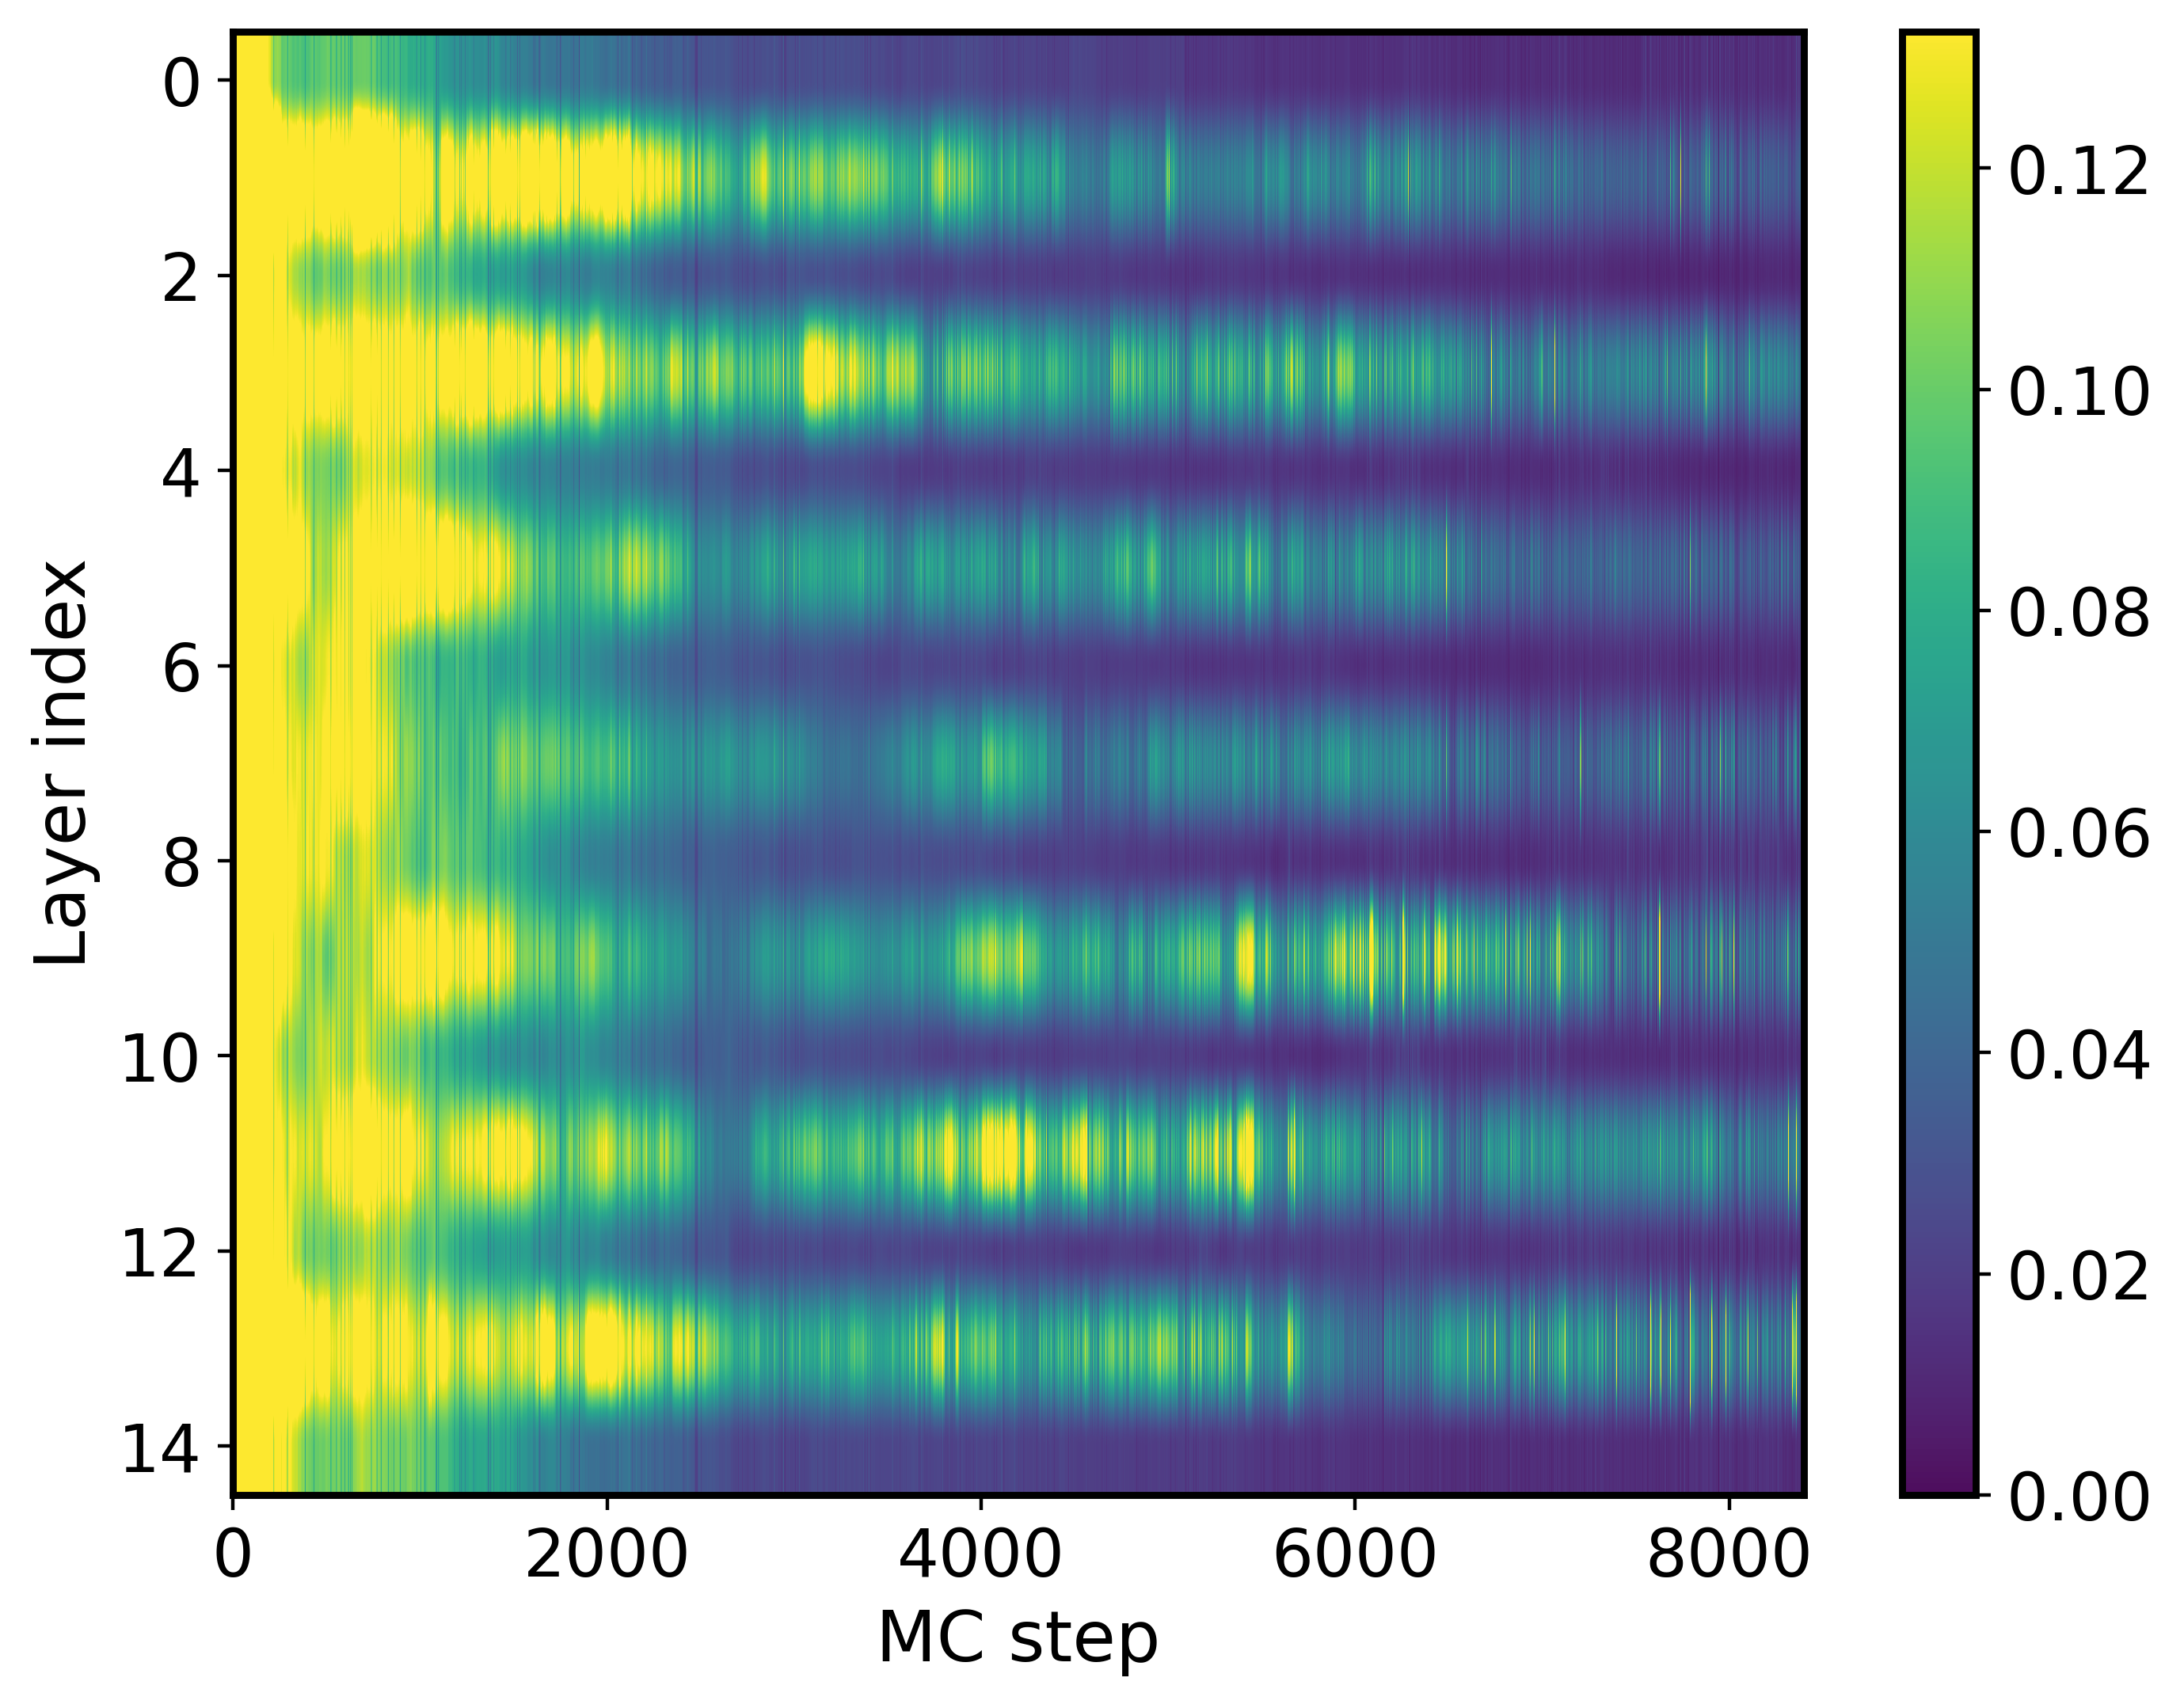

In [64]:
# Set the figure size
plt.figure(figsize=(8, 6), dpi=400)

# Magnify forces
forces_map_magnified = forces_map * 10

# Create a 2D color map of the Cr atom counts with adjustable contrast
plt.imshow(forces_map_magnified, cmap='viridis', aspect='auto', alpha=0.95, 
           vmin=forces_map.min(), vmax=forces_map.max())

# Set the x-axis and y-axis labels and the title of the plot with adjustable fonts

# Set the x-axis ticks and labels
#plt.gca().set_xticklabels([])

# Set the y-axis ticks and labels
#plt.gca().set_yticklabels([])

plt.xlabel("MC step", fontsize=16)
plt.ylabel("Layer index", fontsize=16)

# Adjust the color bar for better contrast control
cbar = plt.colorbar()
cbar.set_ticks(np.arange(0,0.14,0.02))  # Remove the ticks
#cbar.set_ticklabels([])  # Remove the tick labels
plt.rcParams["axes.linewidth"] = 1.6

plt.savefig('forces.png')

# Show the plot
plt.show()


### MC Energy plot

In [12]:
# Read the csv file into a pandas DataFrame
df = pd.read_csv("monte_carlo_results.csv")

In [13]:
import re
import matplotlib.pyplot as plt
from collections import deque

# initialize empty lists to store the extracted data
volumes = []
pxxs = []
pyys = []
pzzs = []
sampled_energies = []

# open the log file and read its contents line by line
with open("MC.out", "r") as f:
    # create a deque with max length 5
    last_five_lines = deque(maxlen=6)
    # loop over each line in the file
    for line in f:
        # append the line to the deque
        last_five_lines.append(line)
        # check if the line contains the header
        if line.startswith('Minimization'):
            # extract the data from the fifth line before the header line
            data = last_five_lines[0].split()
            volumes.append(float(data[2]))
            pxxs.append(float(data[3])/1000)
            pyys.append(float(data[4])/1000)
            pzzs.append(float(data[5])/1000)
            sampled_energies.append(float(data[6]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


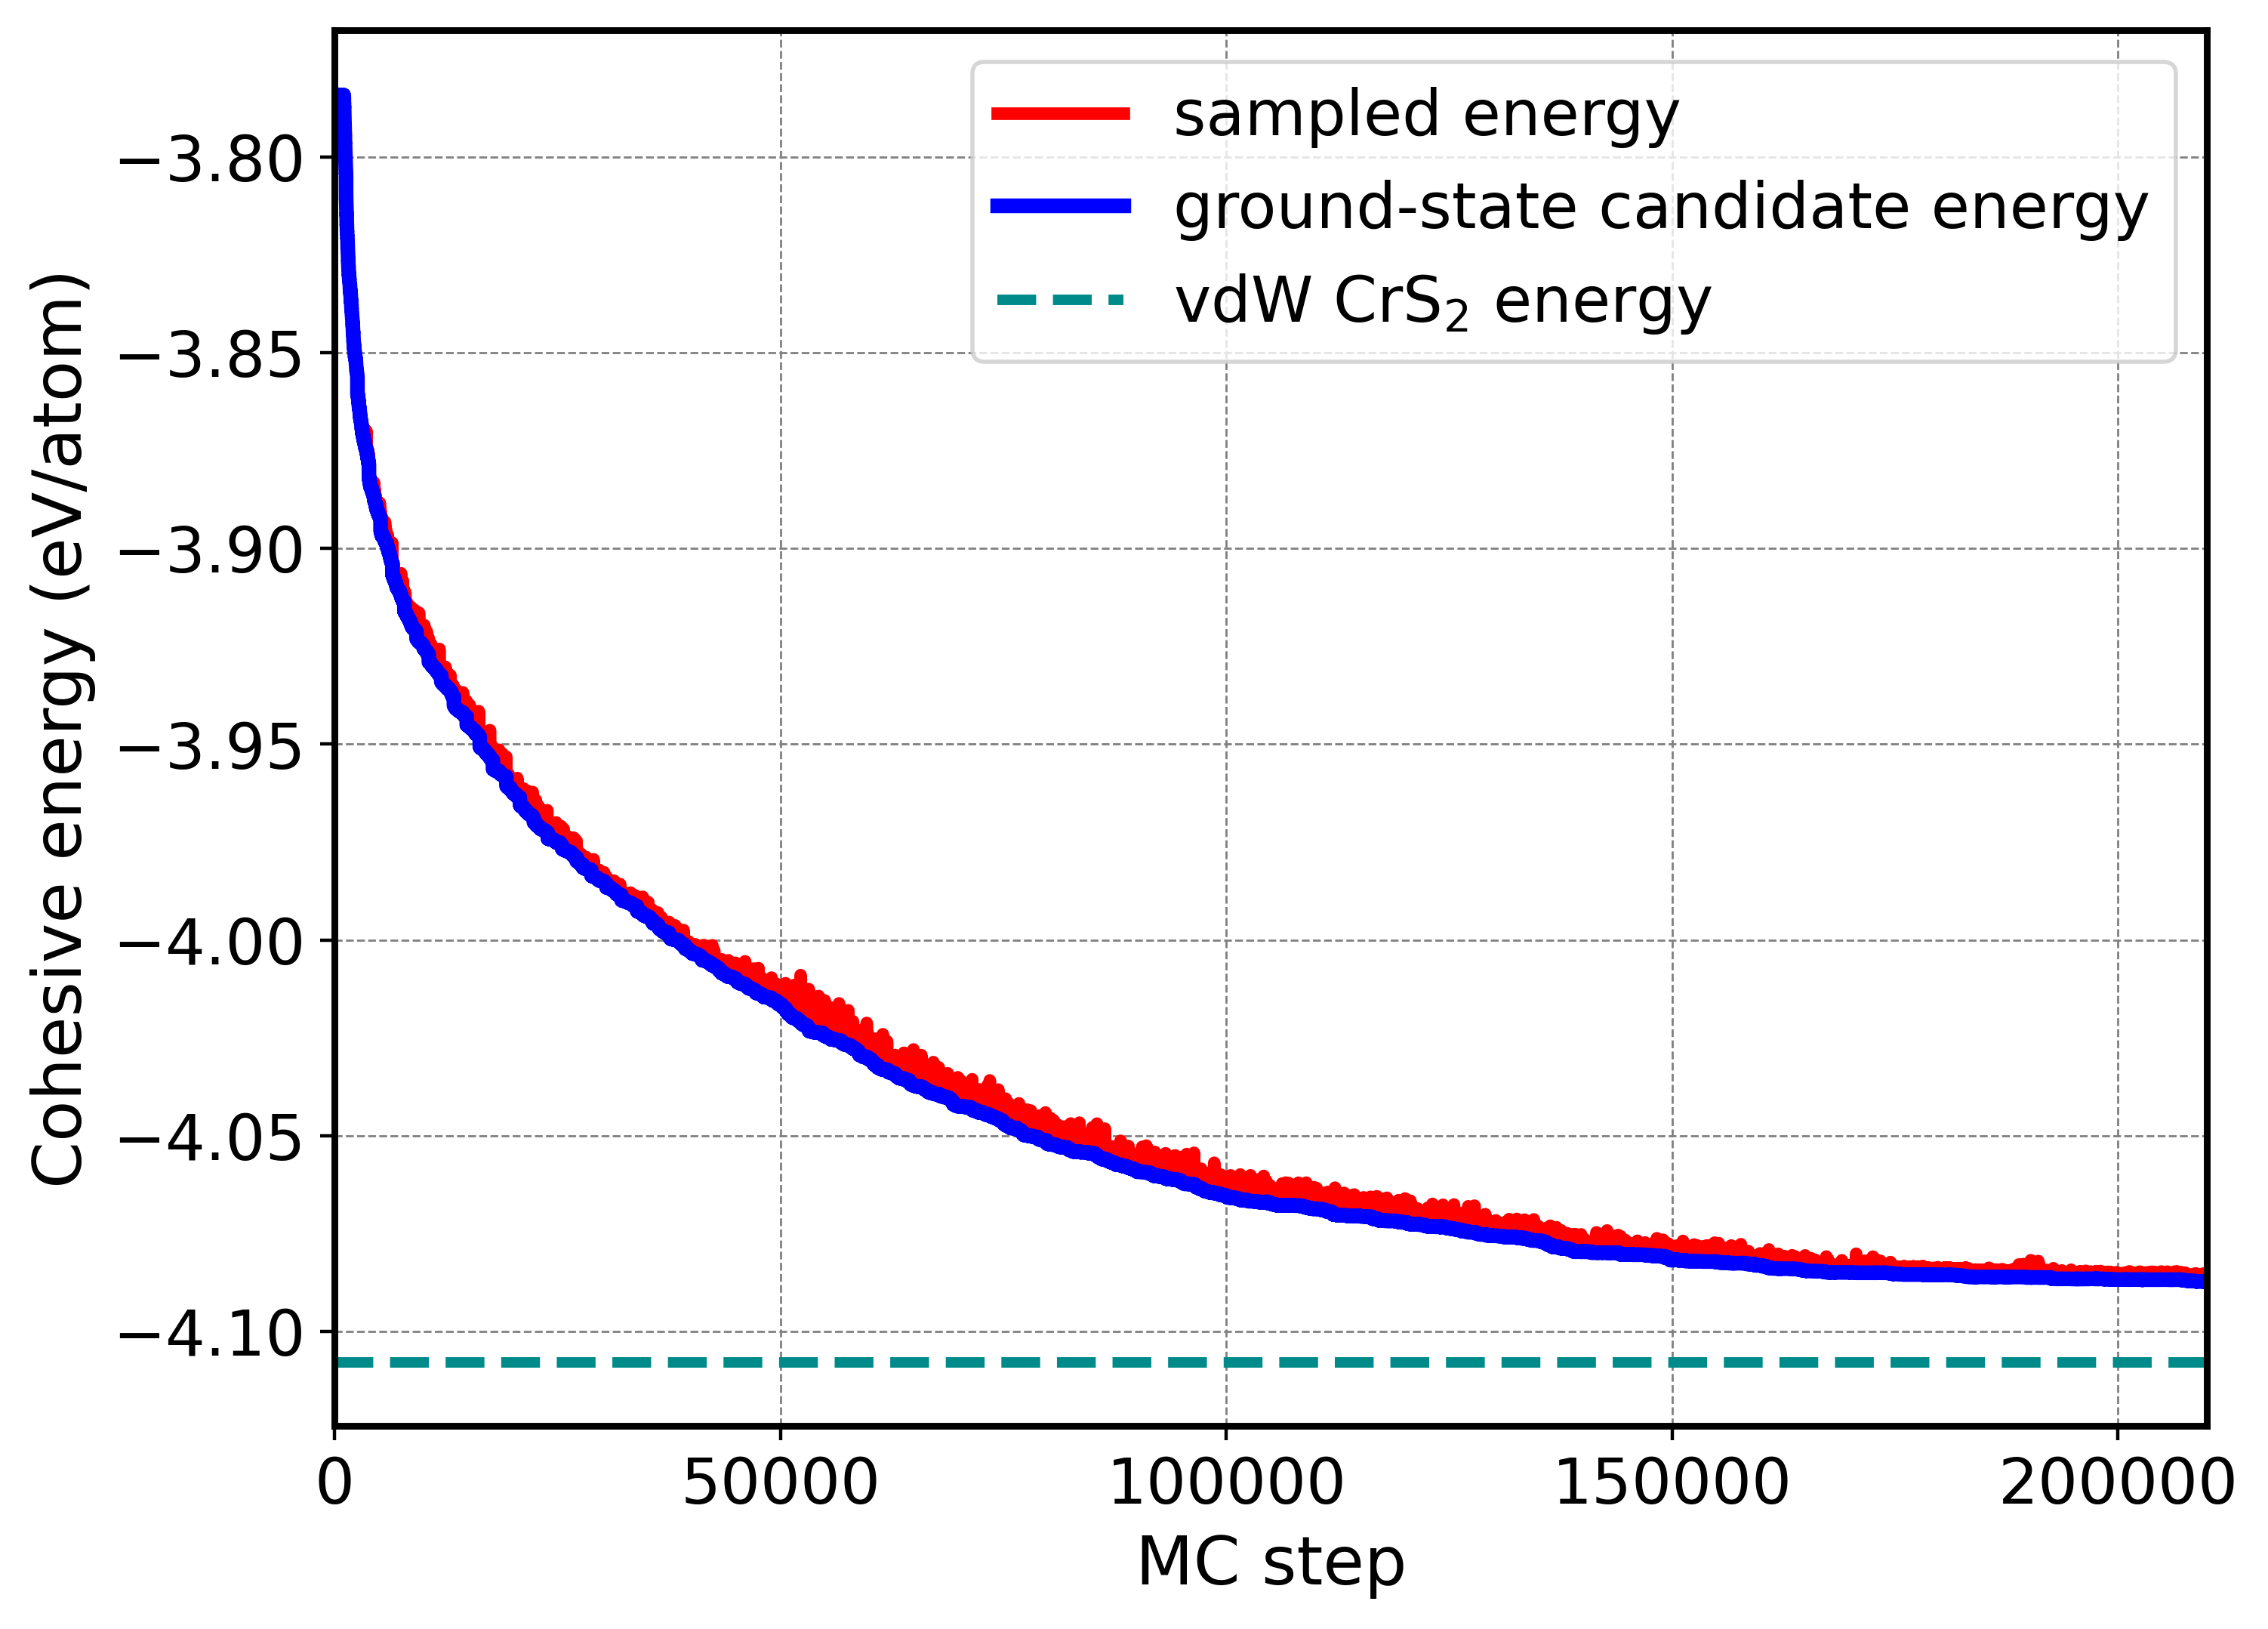

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Set the figure size
plt.figure(figsize=(8, 6), dpi=400)

# Plot the "Sampled Energy" column
plt.plot(df["Monte Carlo Step"], np.array(sampled_energies)[0:210000]/N_atoms, label='sampled energy', 
         linestyle='solid',linewidth=3.0, color='red')
plt.plot(df["Monte Carlo Step"], df["Sampled Energy"], label='ground-state candidate energy', 
         linestyle='solid',linewidth=3.5, color='blue')

# Plot horizontal dashed line
plt.axhline(y=-4.107903513712729, color='darkcyan', linestyle='--', linewidth=2.5, label='vdW CrS$_2$ energy')

# Label the x and y axes
plt.xlabel("MC step", fontsize=16)
plt.ylabel("Cohesive energy (eV/atom)", fontsize=16)
plt.xlim(0, 210000)

# Set line colors and fonts
plt.rcParams['font.size'] = 15

# Set the x ticks every 50,000 MC steps
plt.xticks(np.arange(0, 210001, 50000))

# Remove tick labels
#plt.gca().set_xticklabels([])
#plt.gca().set_yticklabels([])

# Add legend and grid
plt.legend(fontsize=15)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.rcParams["axes.linewidth"] = 1.6
plt.savefig('MC_vdw_energy.eps')
plt.show()


### Pressures 

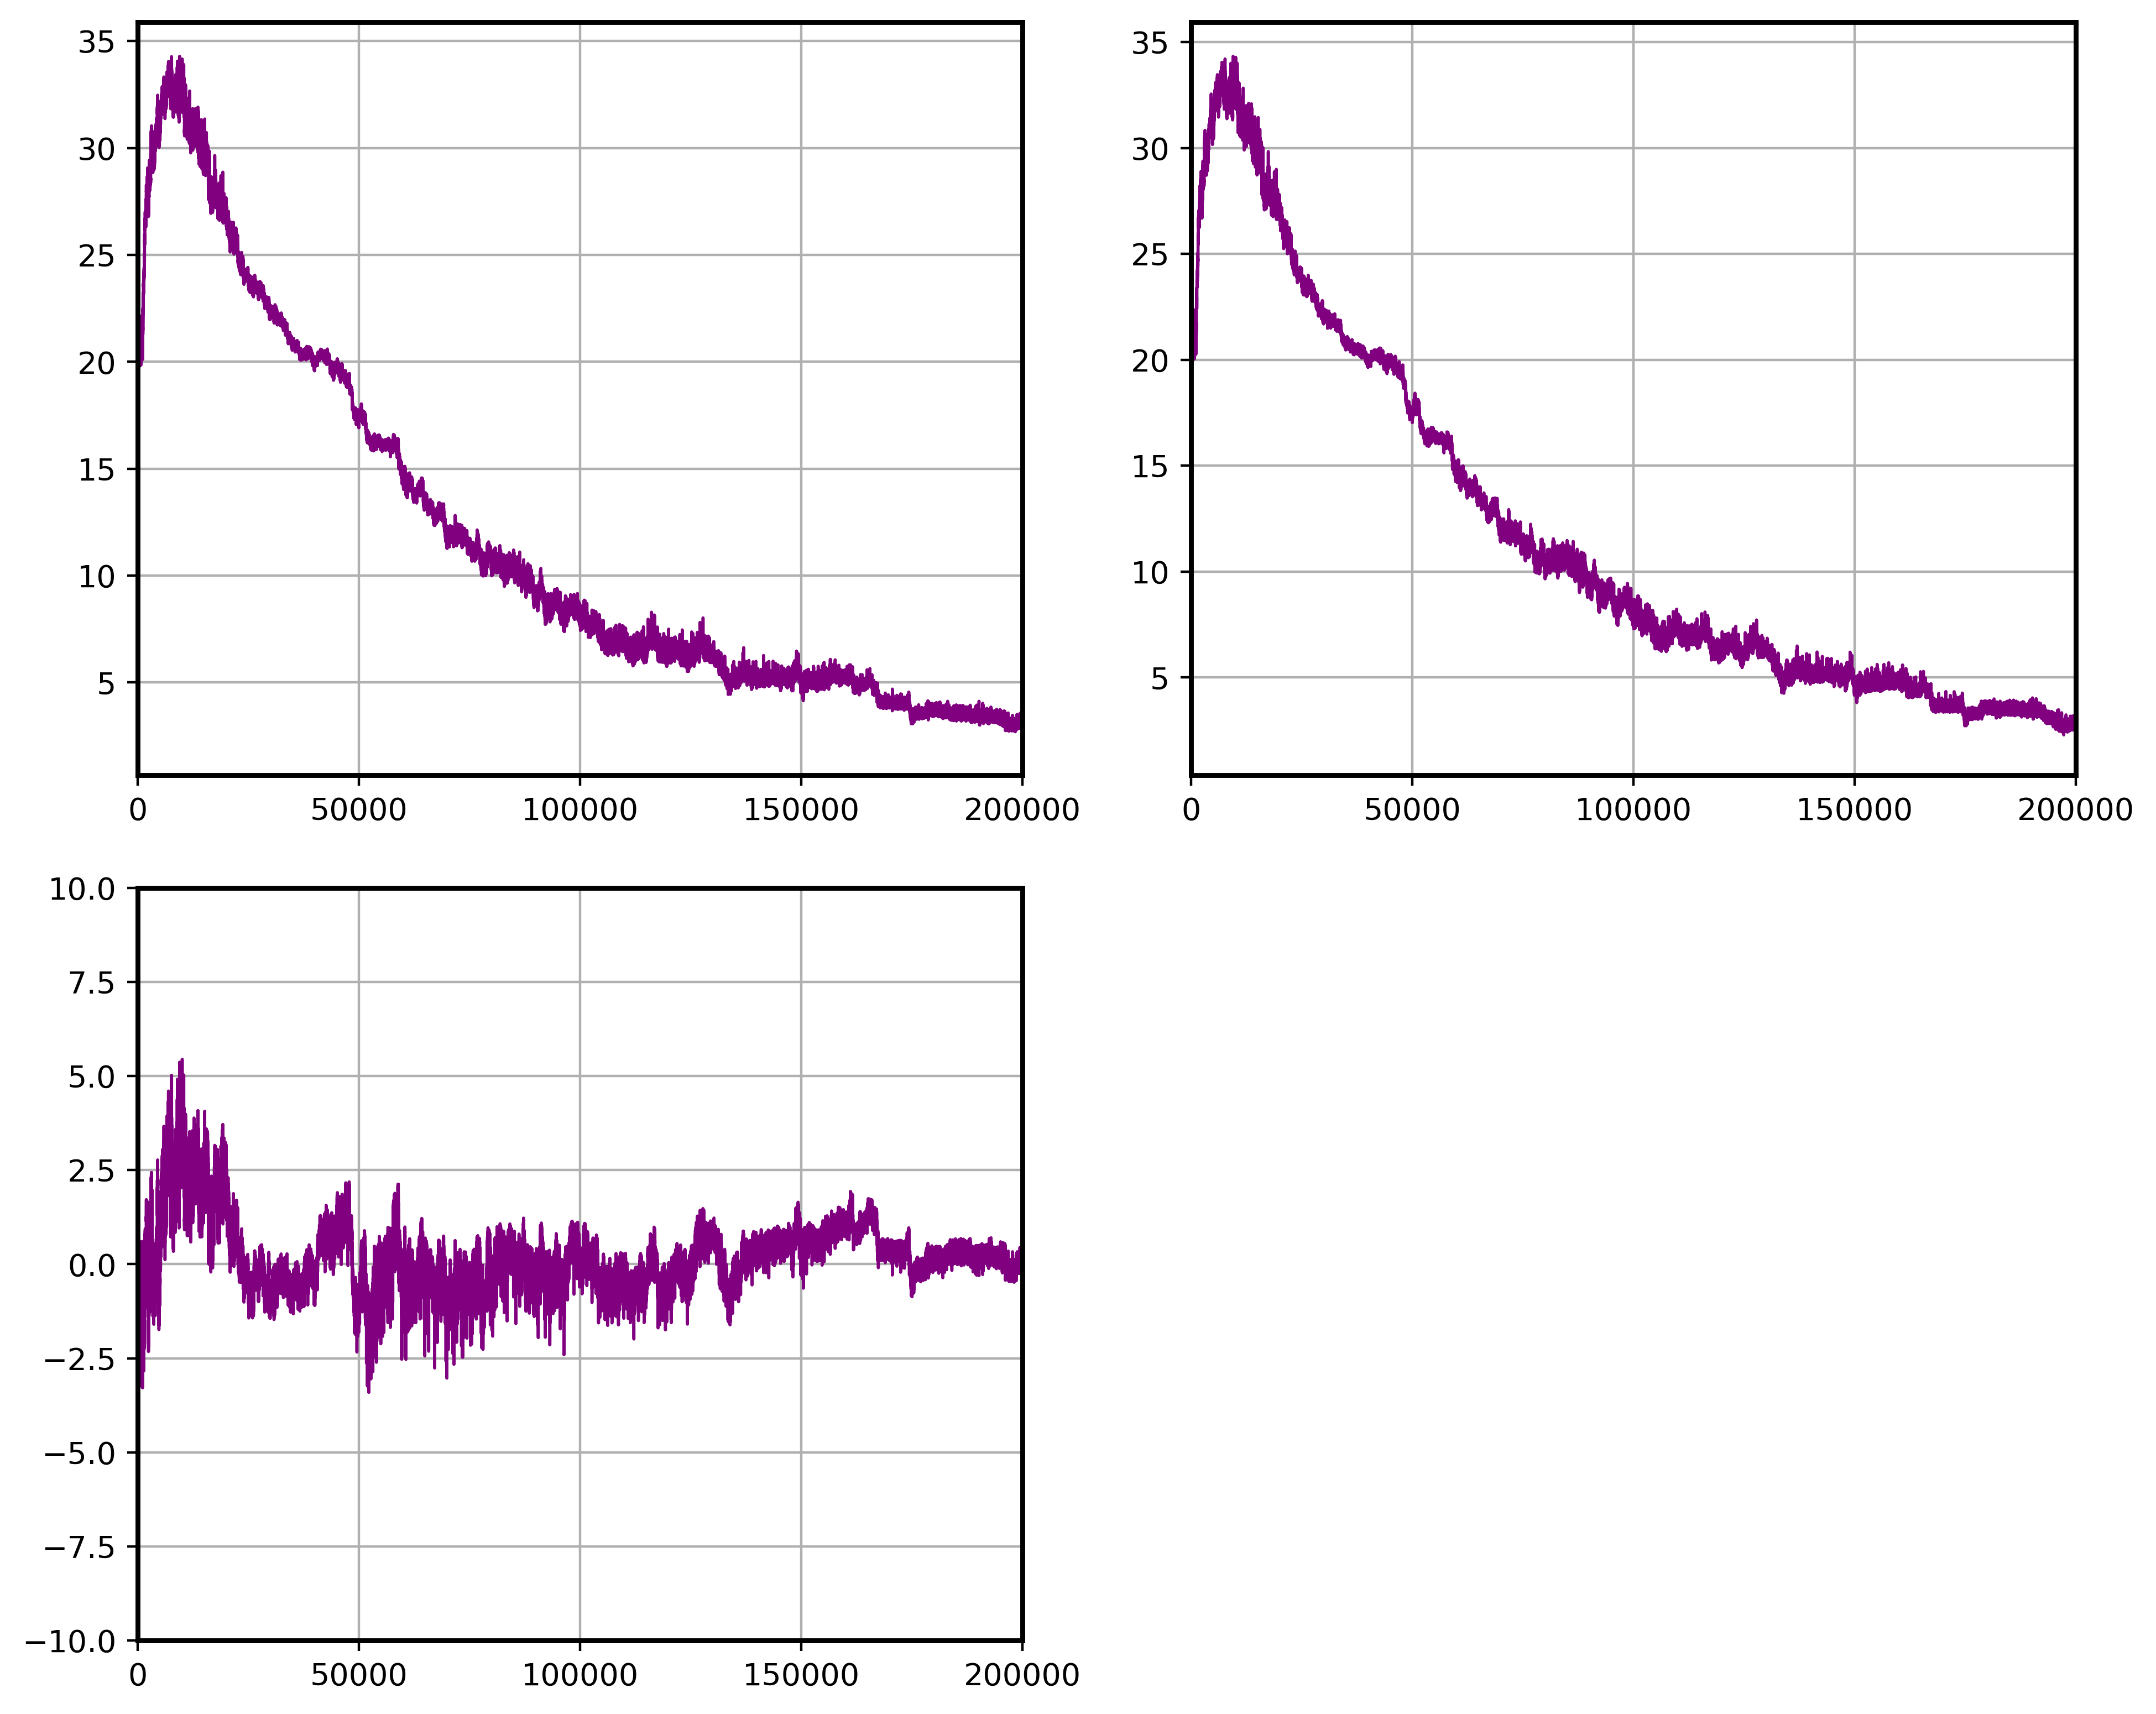

In [66]:
import matplotlib.pyplot as plt

# Create a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(10, 8), dpi=400)  # Adjust the figsize as desired

# Remove the empty subplot in the second row
fig.delaxes(axs[1, 1])

# Unpack the axes
ax1, ax2, ax3, _ = axs.flatten()

# Plot pxxs
ax1.plot(pxxs, color='purple', linewidth=1)
#ax1.set_xticklabels([])
#ax1.set_yticklabels([])
ax1.set_xlim(0, 25000)
ax1.set_xticks(range(0, 210001, 50000))
ax1.grid(True)

# Plot pyys
ax2.plot(pyys, color='purple', linewidth=1)
#ax2.set_xticklabels([])
#ax2.set_yticklabels([])
ax2.set_xlim(0, 25000)
ax2.set_xticks(range(0, 210001, 50000))
ax2.grid(True)

# Plot pzzs
ax3.plot(pzzs, color='purple', linewidth=1)
#ax3.set_xticklabels([])
#ax3.set_yticklabels([])
ax3.set_xlim(0, 25000)
ax3.set_xticks(range(0, 210001, 50000))
ax3.set_ylim(-10, 10)  # Adjust the vertical axis limits
ax3.grid(True)


# Set line fonts and colors
for ax in [ax1,ax2,ax3]:
    ax.xaxis.label.set_fontsize(15)
    ax.yaxis.label.set_fontsize(15)
    ax.tick_params(axis='both', labelsize=10)
    for spine in ax.spines.values():
        spine.set_linewidth(1.6)  # Set the border thickness

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.savefig('pressures.png')
plt.show()


### MC moves

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


x-y/z moves :  1.2139648836259698


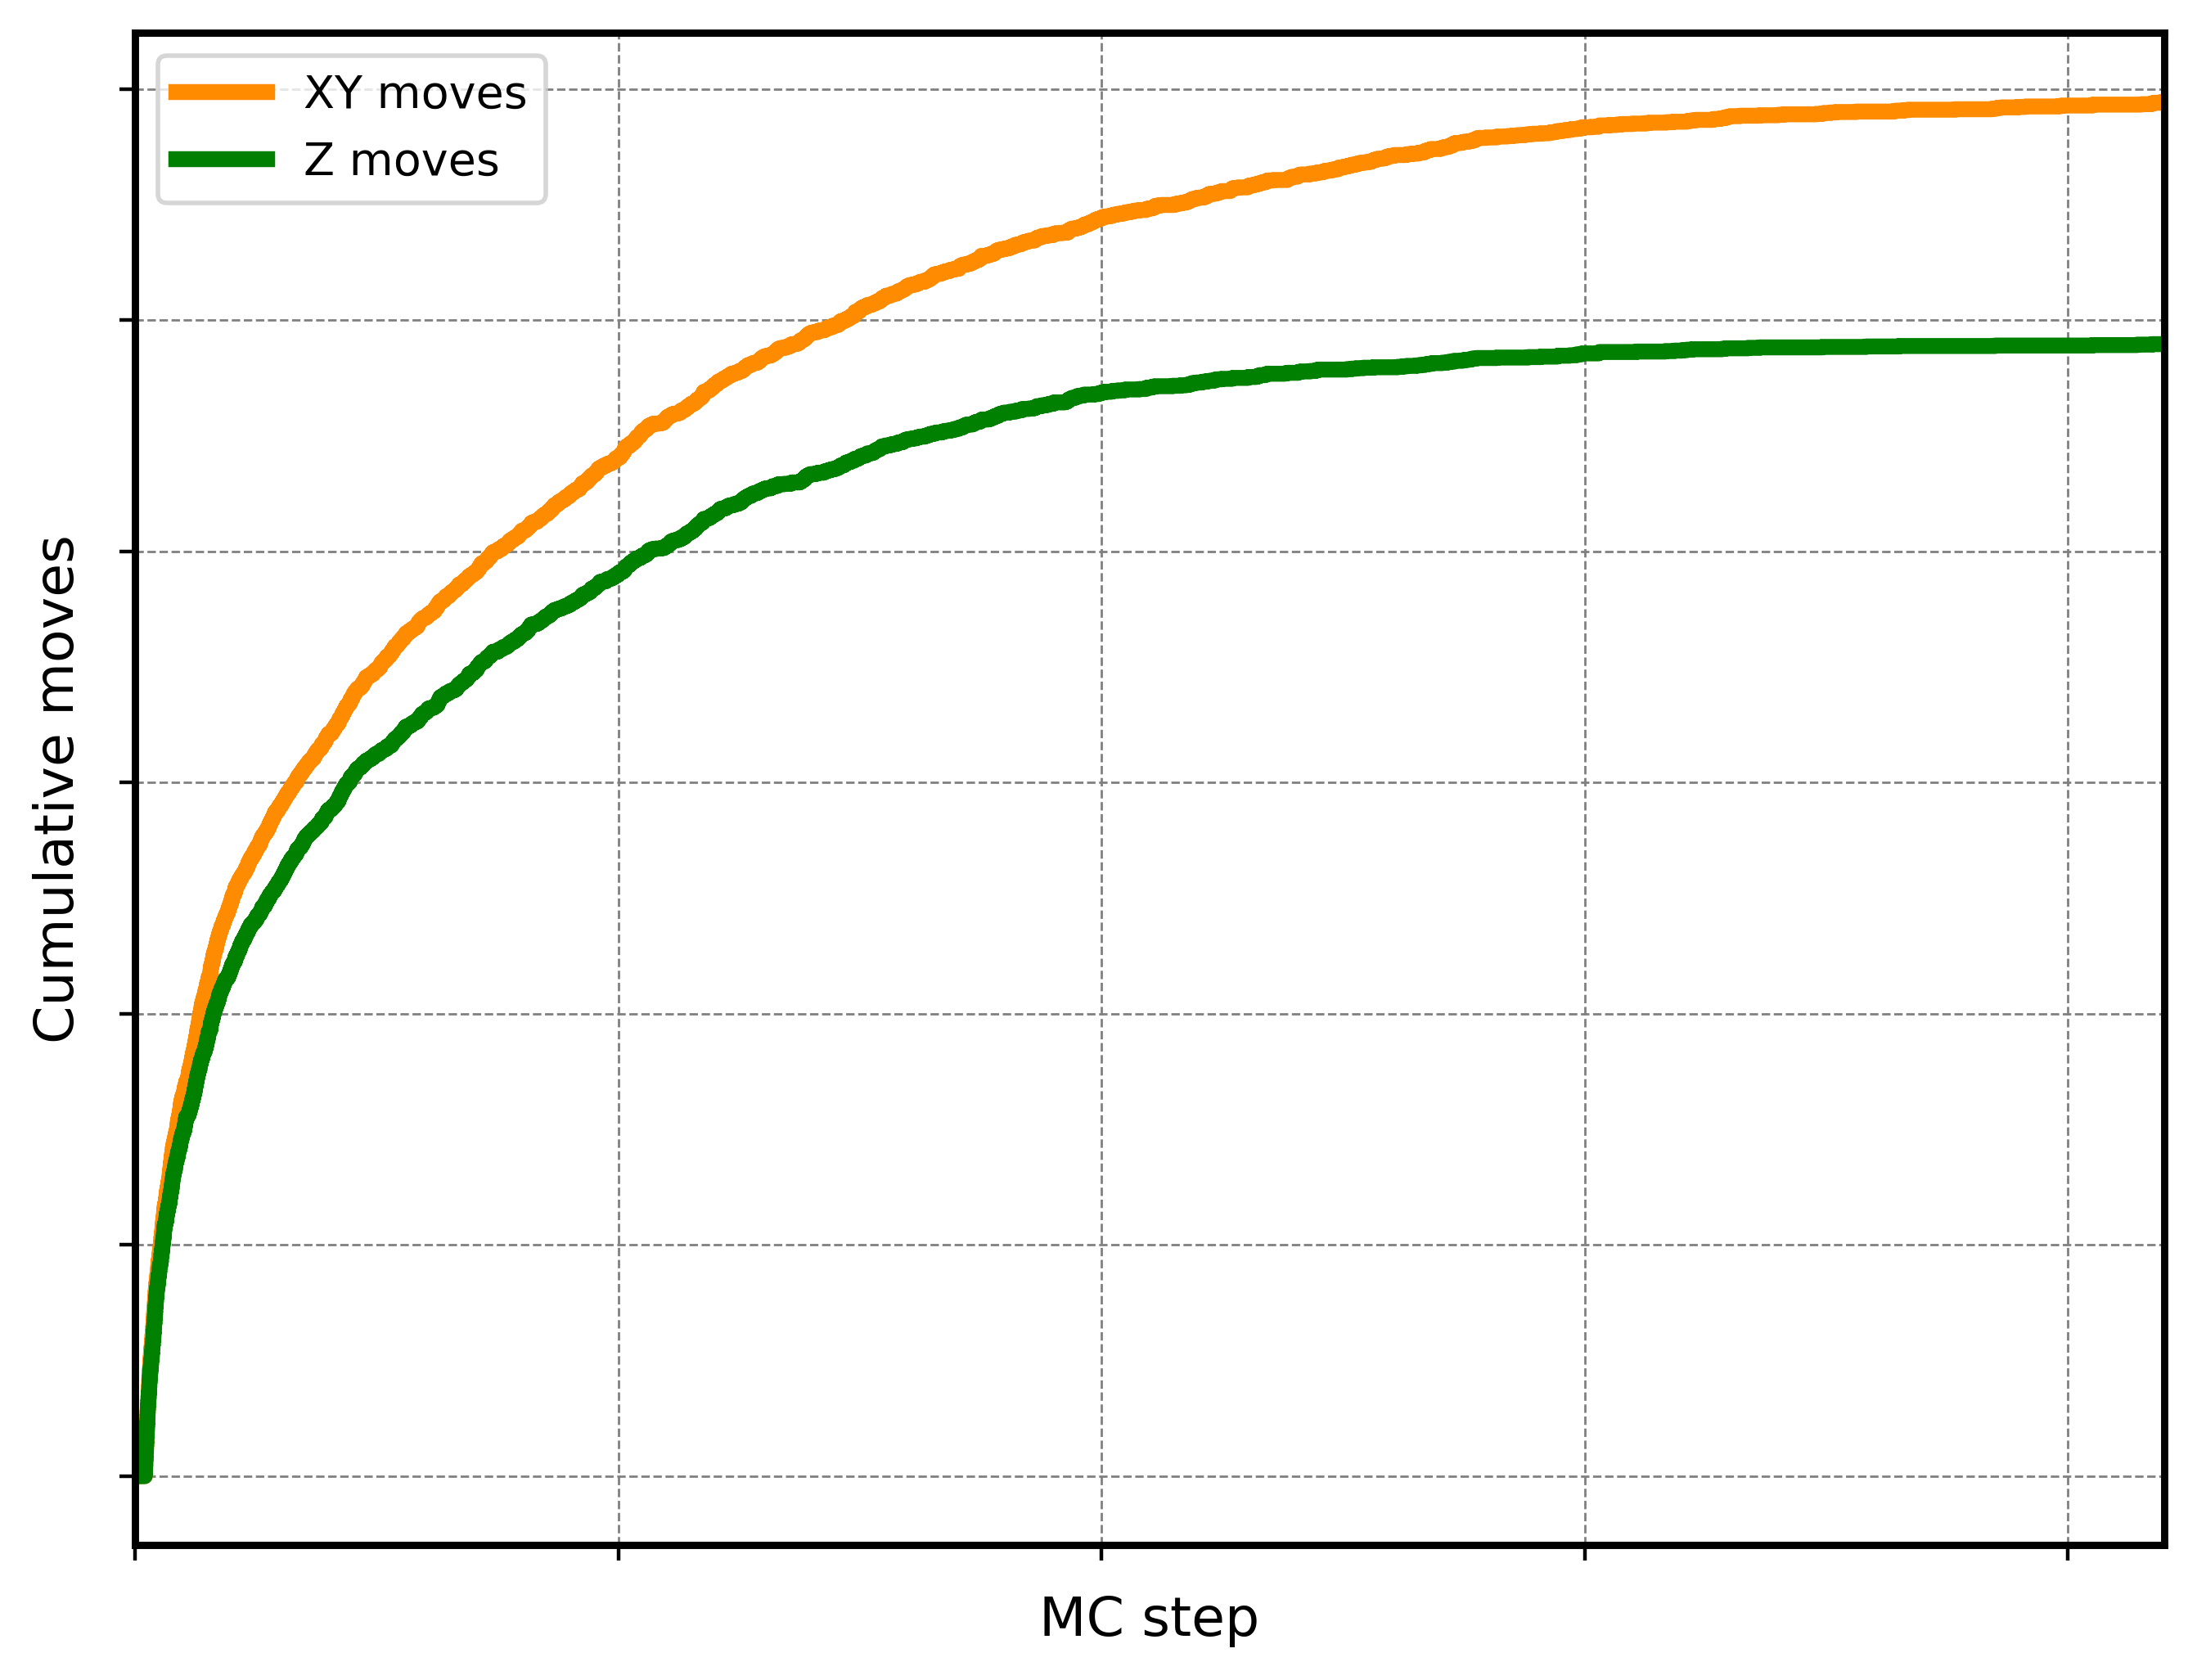

In [70]:
import ast

cumulative_z_moves = np.zeros(len(all_structures))
cumulative_xy_moves = np.zeros(len(all_structures))

# Loop over each mc step and calculate the cumulative function of moves
cumulative_z_moves[0] = 0; cumulative_xy_moves[0] = 0

for i in range(1, len(all_structures)):
    structure = all_structures[i]
    # Check if there was a vacancy diffusion event
    if len(ast.literal_eval(df['chosen_vacs_hist'].iloc[i])) != 0:
        # Get the indices of the atoms that got swapped
        vacs_old_indices = ast.literal_eval(df['chosen_vacs_hist'].iloc[i])
        vacs_new_indices = ast.literal_eval(df['chosen_crs_hist'].iloc[i])
        if len(vacs_new_indices)==len(vacs_old_indices):
            # Check the direction of the swap
            for j, index1 in enumerate(vacs_old_indices):   
                index2 = vacs_new_indices[j]
                if abs(structure[index1].position[2] - structure[index2].position[2]) > 0:
                    z_moves = 1
                if abs(structure[index1].position[0] - structure[index2].position[0]) > 0 or \
                   abs(structure[index1].position[1] - structure[index2].position[1]) > 0:
                    xy_moves = 1
        else:
            print()
            #print(i)
    else:
        z_moves = 0; xy_moves = 0
    # Add the moves to the cumulative function arrays
    cumulative_z_moves[i] = cumulative_z_moves[i-1] + z_moves
    cumulative_xy_moves[i] = cumulative_xy_moves[i-1] + xy_moves
    
# print x-y/z moves
print('x-y/z moves : ', cumulative_xy_moves[-1]/cumulative_z_moves[-1])    

# Plot the cumulative function of moves in xy and z vs time step
plt.figure(figsize=(8, 6), dpi=400)
plt.plot(np.arange(len(all_structures)), cumulative_xy_moves, linewidth=3.5, color='darkorange')
plt.plot(np.arange(len(all_structures)), cumulative_z_moves, linewidth=3.5, color='green')


# Set the x ticks every 50,000 MC steps
plt.xticks(np.arange(0, 210001, 50000))

# Set the x-axis limits to match the range of your data
plt.xlim(0, 210000)

plt.xlabel('MC step', fontsize=12)
plt.ylabel('Cumulative moves', fontsize=12)
plt.legend(['XY moves', 'Z moves'], fontsize=10)


# Remove tick labels
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])

# Add grid
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.rcParams["axes.linewidth"] = 1.6


plt.savefig('XY_jumps.eps')
plt.show()


In [18]:
# Start with vacancy indices at mc_step 0
vac_0_indices = [i for i, at in enumerate(all_structures[0]) if at.symbol=='X']
vac_seq_indices = vac_0_indices.copy()

for j in range(1, 210000):
    if j%2000 == 0:
        print(j)
    structure0 = all_structures[j-1]
    structure1 = all_structures[j]
    # Check if there was a vacancy diffusion event
    x_indices0 = [i for i, at in enumerate(structure0) if at.symbol=='X']
    x_indices1 = [i for i, at in enumerate(structure1) if at.symbol=='X']
    if set(x_indices1) != set(x_indices0):
        # Get the indices of the atoms that were proposed for swapping
        vacs_old_indices = ast.literal_eval(df['chosen_vacs_hist'].iloc[j])
        vacs_new_indices = ast.literal_eval(df['chosen_crs_hist'].iloc[j])
        for k, index1 in enumerate(vacs_old_indices): 
            index2 = vacs_new_indices[k]
            # update vac indices sequentially
            ind = vac_seq_indices.index(index1) # ind is the index in vac_seq_indices to mutate
            vac_seq_indices[ind] = index2

2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000
40000
42000
44000
46000
48000
50000
52000
54000
56000
58000
60000
62000
64000
66000
68000
70000
72000
74000
76000
78000
80000
82000
84000
86000
88000
90000
92000
94000
96000
98000
100000
102000
104000
106000
108000
110000
112000
114000
116000
118000
120000
122000
124000
126000
128000
130000
132000
134000
136000
138000
140000
142000
144000
146000
148000
150000
152000
154000
156000
158000
160000
162000
164000
166000
168000
170000
172000
174000
176000
178000
180000
182000
184000
186000
188000
190000
192000
194000
196000
198000
200000
202000
204000
206000
208000


In [19]:
vac_i_layers = {} 
# Dictionary of vacancy indices in structure_0 and the correspoding layer number they belong to at mc_Step zero
for i, vaci in enumerate(vac_0_indices):
    # Extract the atomic positions and element types
    atoms = all_structures[0]
    positions = atoms.get_positions()
    elements = atoms.get_chemical_symbols()
    # Keep only the Cr/X atoms
    cr_x_indices = [i for i, at in enumerate(atoms) if (at.symbol == 'X' or at.symbol == 'Cr')]
    cr_x_positions = positions[cr_x_indices]
    # Extract the unique z-coordinates of the Cr/X atoms
    z_coords = np.unique(cr_x_positions[:, 2])
    for i_layer in range(len(z_coords)):
        if atoms[vaci].position[2] >= (z_coords[i_layer]-0.1) and \
        atoms[vaci].position[2] < (z_coords[i_layer]+0.1):
            vac_i_layers[vaci] = i_layer  
            

vac_f_layers = {} 
# Dictionary of vacancy indices in structure_0 and the correspoding layer number they belong to at mc_step 250,000         
for i, vacf in enumerate(vac_seq_indices):
    # Extract the atomic positions and element types
    atoms = all_structures[209999]
    positions = atoms.get_positions()
    elements = atoms.get_chemical_symbols()
    # Keep only the Cr/X atoms
    cr_x_indices = [i for i, at in enumerate(atoms) if (at.symbol == 'X' or at.symbol == 'Cr')]
    cr_x_positions = positions[cr_x_indices]
    # Extract the unique z-coordinates of the Cr/X atoms
    z_coords = np.unique(cr_x_positions[:, 2])
    for i_layer in range(len(z_coords)):
        if atoms[vacf].position[2] >= (z_coords[i_layer]-0.1) and \
        atoms[vacf].position[2] < (z_coords[i_layer]+0.1):
            vac_f_layers[vacf] = i_layer              

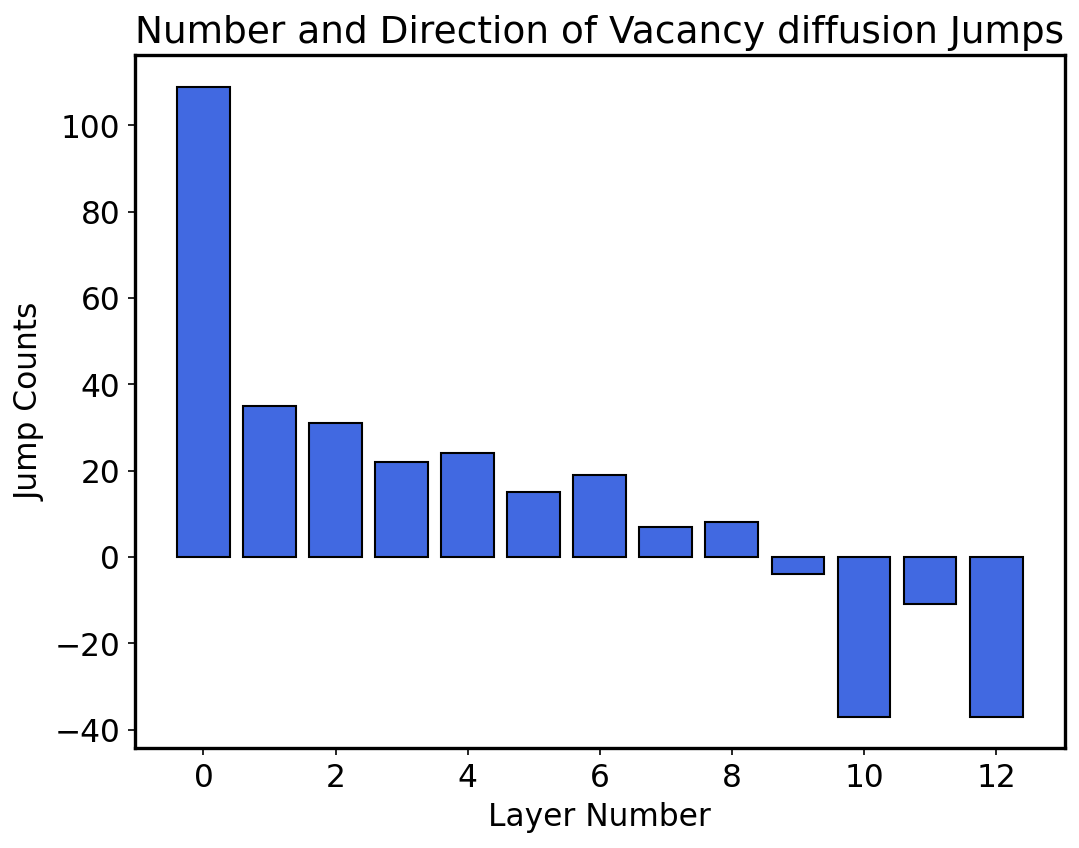

In [20]:
import matplotlib.pyplot as plt

# Initialize a dictionary to store the counts of jumps for each layer
layer_jump_counts_pos = {}
layer_jump_counts_neg = {}

vacancies = list(vac_i_layers.keys())
initial_layer_numbers = list(vac_i_layers.values())
final_layer_numbers = list(vac_f_layers.values())

# Loop over the vacancies and their initial and final layer numbers
for vacancy, initial_layer, final_layer in zip(vacancies, initial_layer_numbers, final_layer_numbers):
    # Calculate the layer jump
    layer_jump = final_layer - initial_layer

    # Update the counts in the dictionary
    if layer_jump > 0:
        if initial_layer in layer_jump_counts_pos:
            layer_jump_counts_pos[initial_layer] += 1
        else:
            layer_jump_counts_pos[initial_layer] = 1
    elif layer_jump < 0:
        if initial_layer in layer_jump_counts_neg:
            layer_jump_counts_neg[initial_layer] -= 1
        else:
            layer_jump_counts_neg[initial_layer] = -1    

# Extract the layer numbers and counts for plotting
layer_numbers = list(layer_jump_counts_pos.keys())
jump_counts_pos = list(layer_jump_counts_pos.values())
jump_counts_neg = list(layer_jump_counts_neg.values())

# Set the figure size and dpi
plt.figure(figsize=(8, 6), dpi=150)

# Plot the histogram with borders and positive jump counts
#plt.bar(layer_numbers, jump_counts_pos, edgecolor='black', color='skyblue')

# Plot the negative jump counts with a different color and adjusted positions
#plt.bar(layer_numbers, jump_counts_neg, edgecolor='black', color='salmon')

# Calculate the sum of the positive and negative jump counts
jump_counts_sum = [pos + neg for pos, neg in zip(jump_counts_pos, jump_counts_neg)]

# Plot the sum of jump counts with a different color
plt.bar(layer_numbers, jump_counts_sum, edgecolor='black', color='royalblue')

plt.xlabel('Layer Number')
plt.ylabel('Jump Counts')
plt.title('Number and Direction of Vacancy diffusion Jumps')
plt.savefig('vacancy_diffusivity.eps')
# Display the plot
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


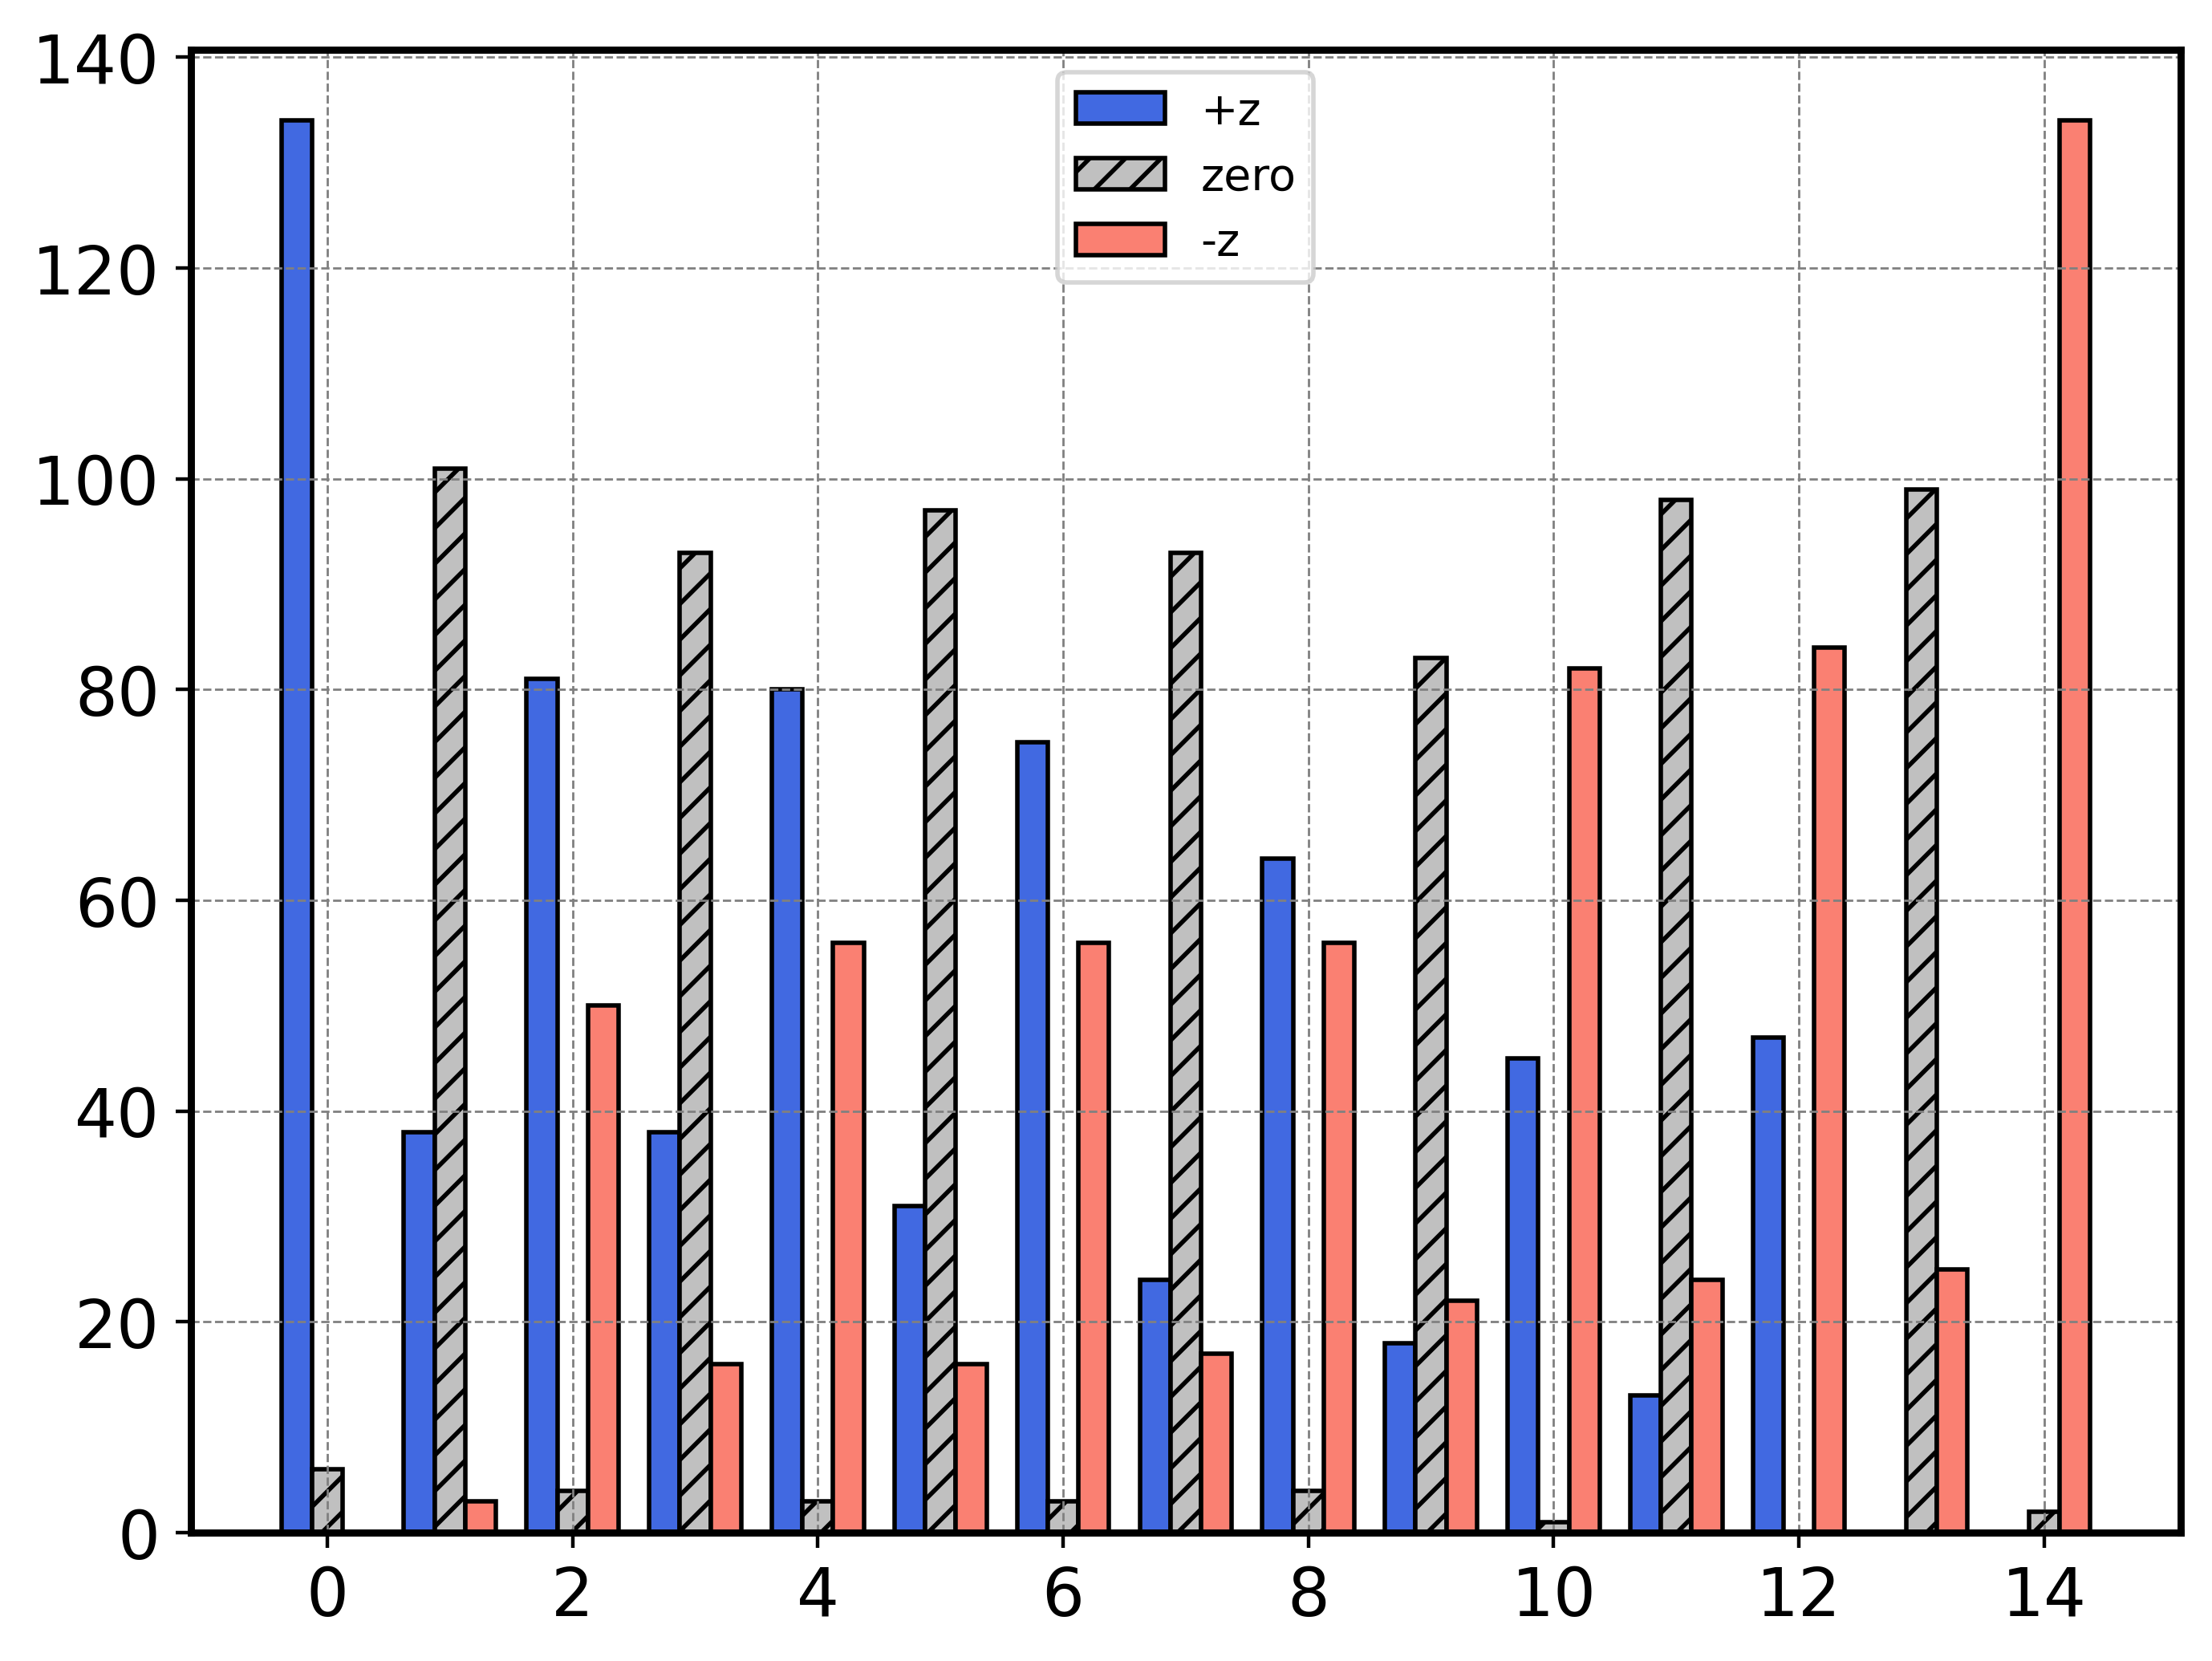

In [72]:
import matplotlib.pyplot as plt

# Initialize a dictionary to store the counts of jumps for each layer
layer_jump_counts_pos = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0,13:0,14:0}
layer_jump_counts_neg = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0,13:0,14:0}
layer_jump_counts_zero = {0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0,13:0,14:0}

vacancies = list(vac_i_layers.keys())
initial_layer_numbers = list(vac_i_layers.values())
final_layer_numbers = list(vac_f_layers.values())

# Loop over the vacancies and their initial and final layer numbers
for vacancy, initial_layer, final_layer in zip(vacancies, initial_layer_numbers, final_layer_numbers):
    # Calculate the layer jump
    layer_jump = final_layer - initial_layer
    
    if layer_jump > 0:
        # Update the counts in the dictionary
        layer_jump_counts_pos[initial_layer] += 1
    elif layer_jump < 0:
        # Update the counts in the dictionary
        layer_jump_counts_neg[initial_layer] += 1
    elif layer_jump == 0:       
        # Update the counts in the dictionary
        layer_jump_counts_zero[initial_layer] += 1
            

# Extract the layer numbers and counts for plotting
layer_numbers = list(layer_jump_counts_pos.keys())
jump_counts_pos = list(layer_jump_counts_pos.values())
jump_counts_neg = list(layer_jump_counts_neg.values())
jump_counts_zero = list(layer_jump_counts_zero.values())



# Set the figure size and dpi
plt.figure(figsize=(8, 6), dpi=400)

# Set the width of each bar
width = 0.25

# Set the positions for the bars in each group
position = np.arange(len(layer_numbers))

# Plot the histogram
plt.bar(position - width, jump_counts_pos, width=width, edgecolor='black', color='royalblue', label='+z')
plt.bar(position, jump_counts_zero, width=width, edgecolor='black', color='silver', hatch='///', label='zero')  # Add hatch pattern
plt.bar(position + width, jump_counts_neg, width=width, edgecolor='black', color='salmon', label='-z')

# Adjust the x-axis ticks and labels
plt.xticks(position, layer_numbers)



# Set the x ticks every 50,000 MC steps
plt.xticks(np.arange(0, 15, 2))

# Remove tick labels
#plt.gca().set_xticklabels([])
#plt.gca().set_yticklabels([])

plt.legend(fontsize=10)

# Add grid
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.rcParams["axes.linewidth"] = 1.6

plt.savefig('vacancy_jump_directions.eps')

# Show the plot
plt.show()


In [24]:
# Loop over the vacancies and their initial and final layer numbers
vacancies = list(vac_i_layers.keys())
initial_layer_numbers = list(vac_i_layers.values())
final_layer_numbers = list(vac_f_layers.values())

# Initialize a list to store the number of jumps for each vacancy
num_jumps = []

for vacancy, initial_layer, final_layer in zip(vacancies, initial_layer_numbers, final_layer_numbers):
    # Calculate the number of jumps
    num_jumps.append(final_layer - initial_layer)

In [25]:
from collections import Counter

# Count the occurrences of values in num_jumps
jump_counts = Counter(num_jumps)

# Convert the Counter object to a dictionary
jump_counts_dict = dict(jump_counts)

# Print the dictionary
print(jump_counts_dict)


{4: 10, 0: 687, 2: 145, 1: 486, -1: 481, -2: 116, -3: 39, 3: 43, 5: 3, 7: 1, -5: 1, -4: 4}


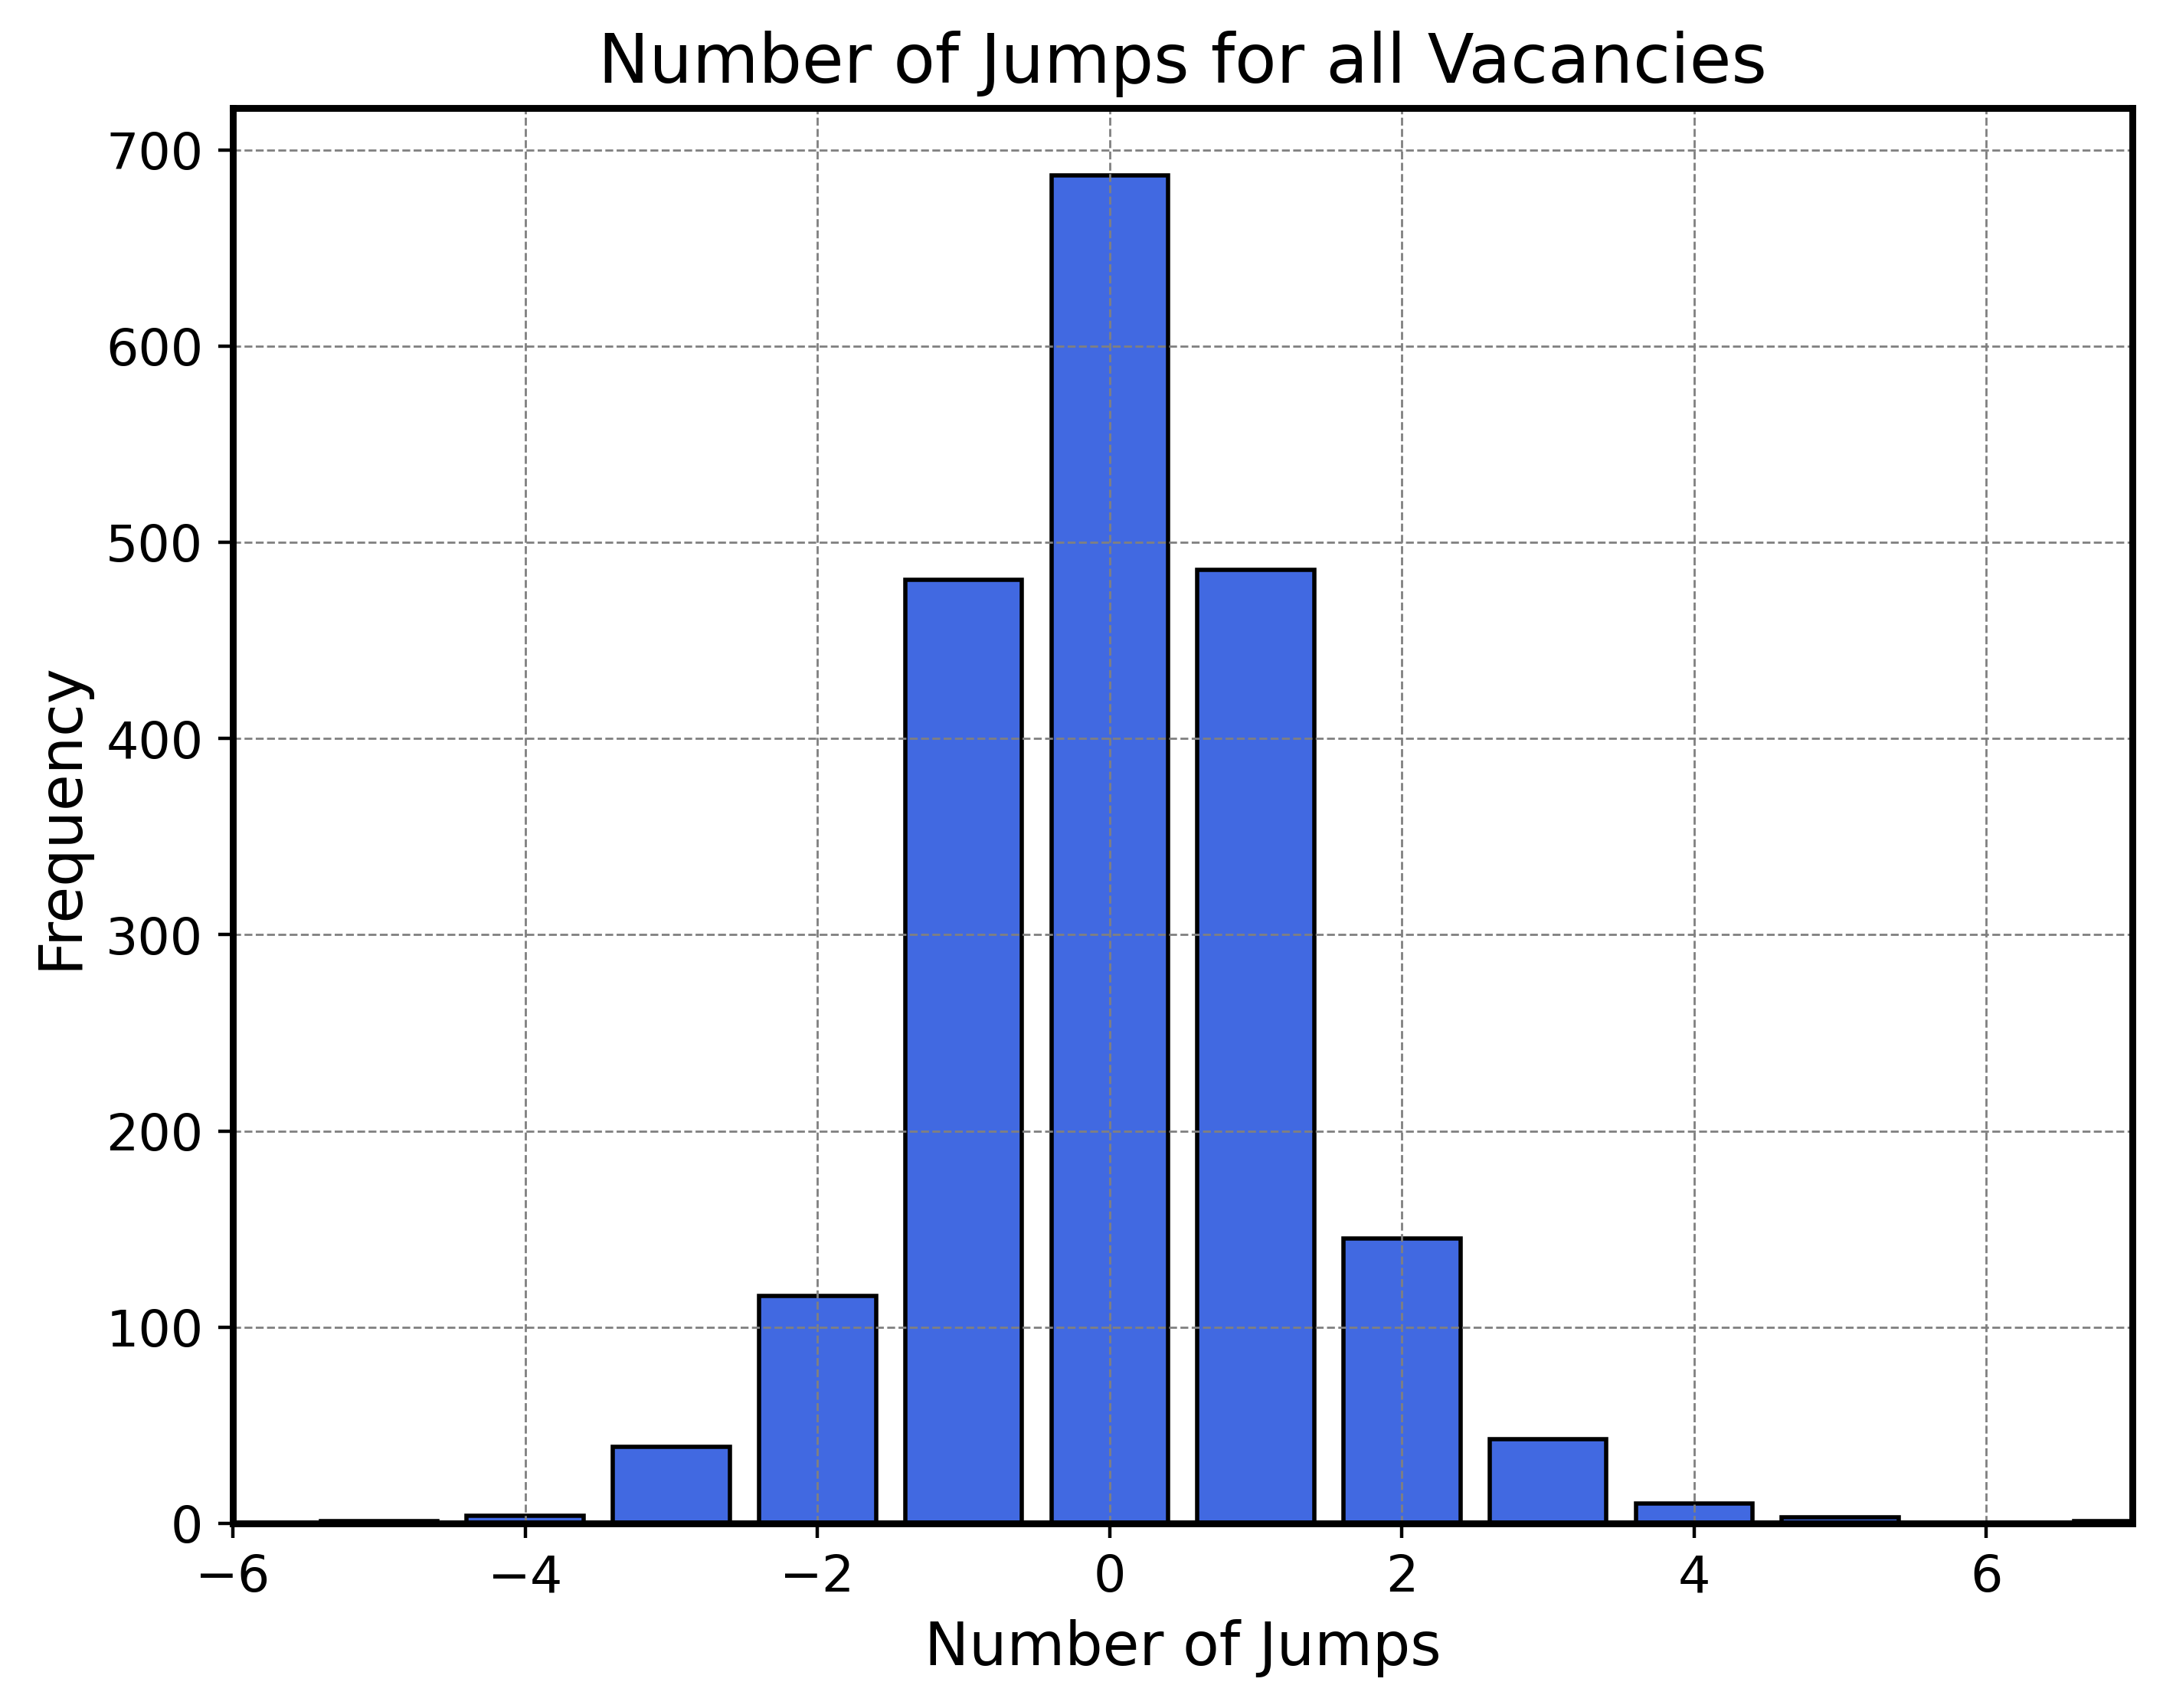

In [75]:
# Get the keys and values from the jump_counts_dict dictionary
jump_values = list(jump_counts_dict.keys())
jump_counts = list(jump_counts_dict.values())

# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 6), dpi=400)

# Plot the bar chart
ax.bar(jump_values, jump_counts, color='royalblue', edgecolor='black')


# Adjust tick font sizes
ax.tick_params(axis='both', labelsize=12)

# Set labels and title with adjusted font sizes
ax.set_xlabel('Number of Jumps', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('Number of Jumps for all Vacancies', fontsize=16)

# Adjust tick font sizes
ax.tick_params(axis='both', labelsize=12)


ax.set_xlim(-6, 7)
ax.set_xticks(range(-6, 8, 2))

# Add grid
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.rcParams["axes.linewidth"] = 1.6

# Remove tick labels
#plt.gca().set_xticklabels([])
#plt.gca().set_yticklabels([])

plt.savefig('vacancy_jumps_bar.png')

plt.show()


In [76]:
total_jumps = sum(jump_counts_dict.values())
print("Total Jumps:", total_jumps)

key_sets = [(-4, 4), (-3, 3), (-2, 2), (-1, 1), (0,)]

for key_set in key_sets:
    total_for_set = sum(jump_counts_dict[key] for key in key_set)
    ratio = total_for_set / total_jumps * 100
    print(f"Ratio for keys {key_set}: {ratio:.4f}")

Total Jumps: 2016
Ratio for keys (-4, 4): 0.6944
Ratio for keys (-3, 3): 4.0675
Ratio for keys (-2, 2): 12.9464
Ratio for keys (-1, 1): 47.9663
Ratio for keys (0,): 34.0774


### Layer thickness over MC steps

In [35]:
atomss = []
# Analyze forces
for i in range(0,210000,25):
    # Read LAMMPS data file as an ASE Atoms object
    data_file_str = './data_files/file-'+str(i)+'_i.dat'
    atoms = lammpsdata.read_lammps_data(file = data_file_str, style = "atomic", sort_by_id=True)

    for at in atoms:
        if at.symbol == 'H':
            at.symbol = 'Cr'
        elif at.symbol == 'He':
            at.symbol = 'S'
    atomss.append(atoms)

In [36]:
atomssf = []
for i in range(0,210000,25):
    # Read LAMMPS data file as an ASE Atoms object
    data_file_str = './data_files/file-'+str(i)+'_f.dat'
    atoms = lammpsdata.read_lammps_data(file = data_file_str, style = "atomic", sort_by_id=True)

    for at in atoms:
        if at.symbol == 'H':
            at.symbol = 'Cr'
        elif at.symbol == 'He':
            at.symbol = 'S'

    atomssf.append(atoms)

In [37]:
z_avg_by_layer_traj = []

# Calculate the average z-coordinate for each group of S atoms in a different layer  
for j in range(len(atomssf)):
    # Get the z-coordinates of the Cr and X atoms
    s_indices = [i for i, at in enumerate(atomss[j]) if at.symbol == 'S']
    z_s = atomss[j].get_positions()[s_indices, 2]
    unique_z = np.unique(z_s)
    s_indices_by_layer = {'0': [], '1': [], '2': [], '3': [], '4': [], '5': [], '6': [], 
                          '7': [], '8': [], '9': [], '10': [],
                          '11': [], '12': [], '13': [], '14': [], '15': []}
    
    # Loop over the S atom indices and assign them to the corresponding layer in the dictionary
    for s_index in s_indices:
        z_coordinate = atomss[j].get_positions()[s_index, 2]
        l = s_indices_by_layer[str(np.where(unique_z == z_coordinate)[0][0])]
        l.append(s_index)
        s_indices_by_layer[str(np.where(unique_z == z_coordinate)[0][0])] = l
        
    z_avg_by_layer = []
    
    for i in s_indices_by_layer:
        average_z = np.mean(atomssf[j].get_positions()[s_indices_by_layer[i], 2])
        z_avg_by_layer.append(average_z)
    z_avg_by_layer_traj.append(z_avg_by_layer)

In [38]:
layer_thicknesses_traj = []

# Calculate layer thicknesses for each structure in z_avg_by_layer_traj
for z_avg_by_layer in z_avg_by_layer_traj:
    layer_thicknesses = []
    for i in range(len(z_avg_by_layer) - 1):
        thickness = z_avg_by_layer[i+1] - z_avg_by_layer[i]
        layer_thicknesses.append(thickness)
    layer_thicknesses_traj.append(layer_thicknesses)
    
layer_thicknesses_traj = np.array(layer_thicknesses_traj).transpose()  

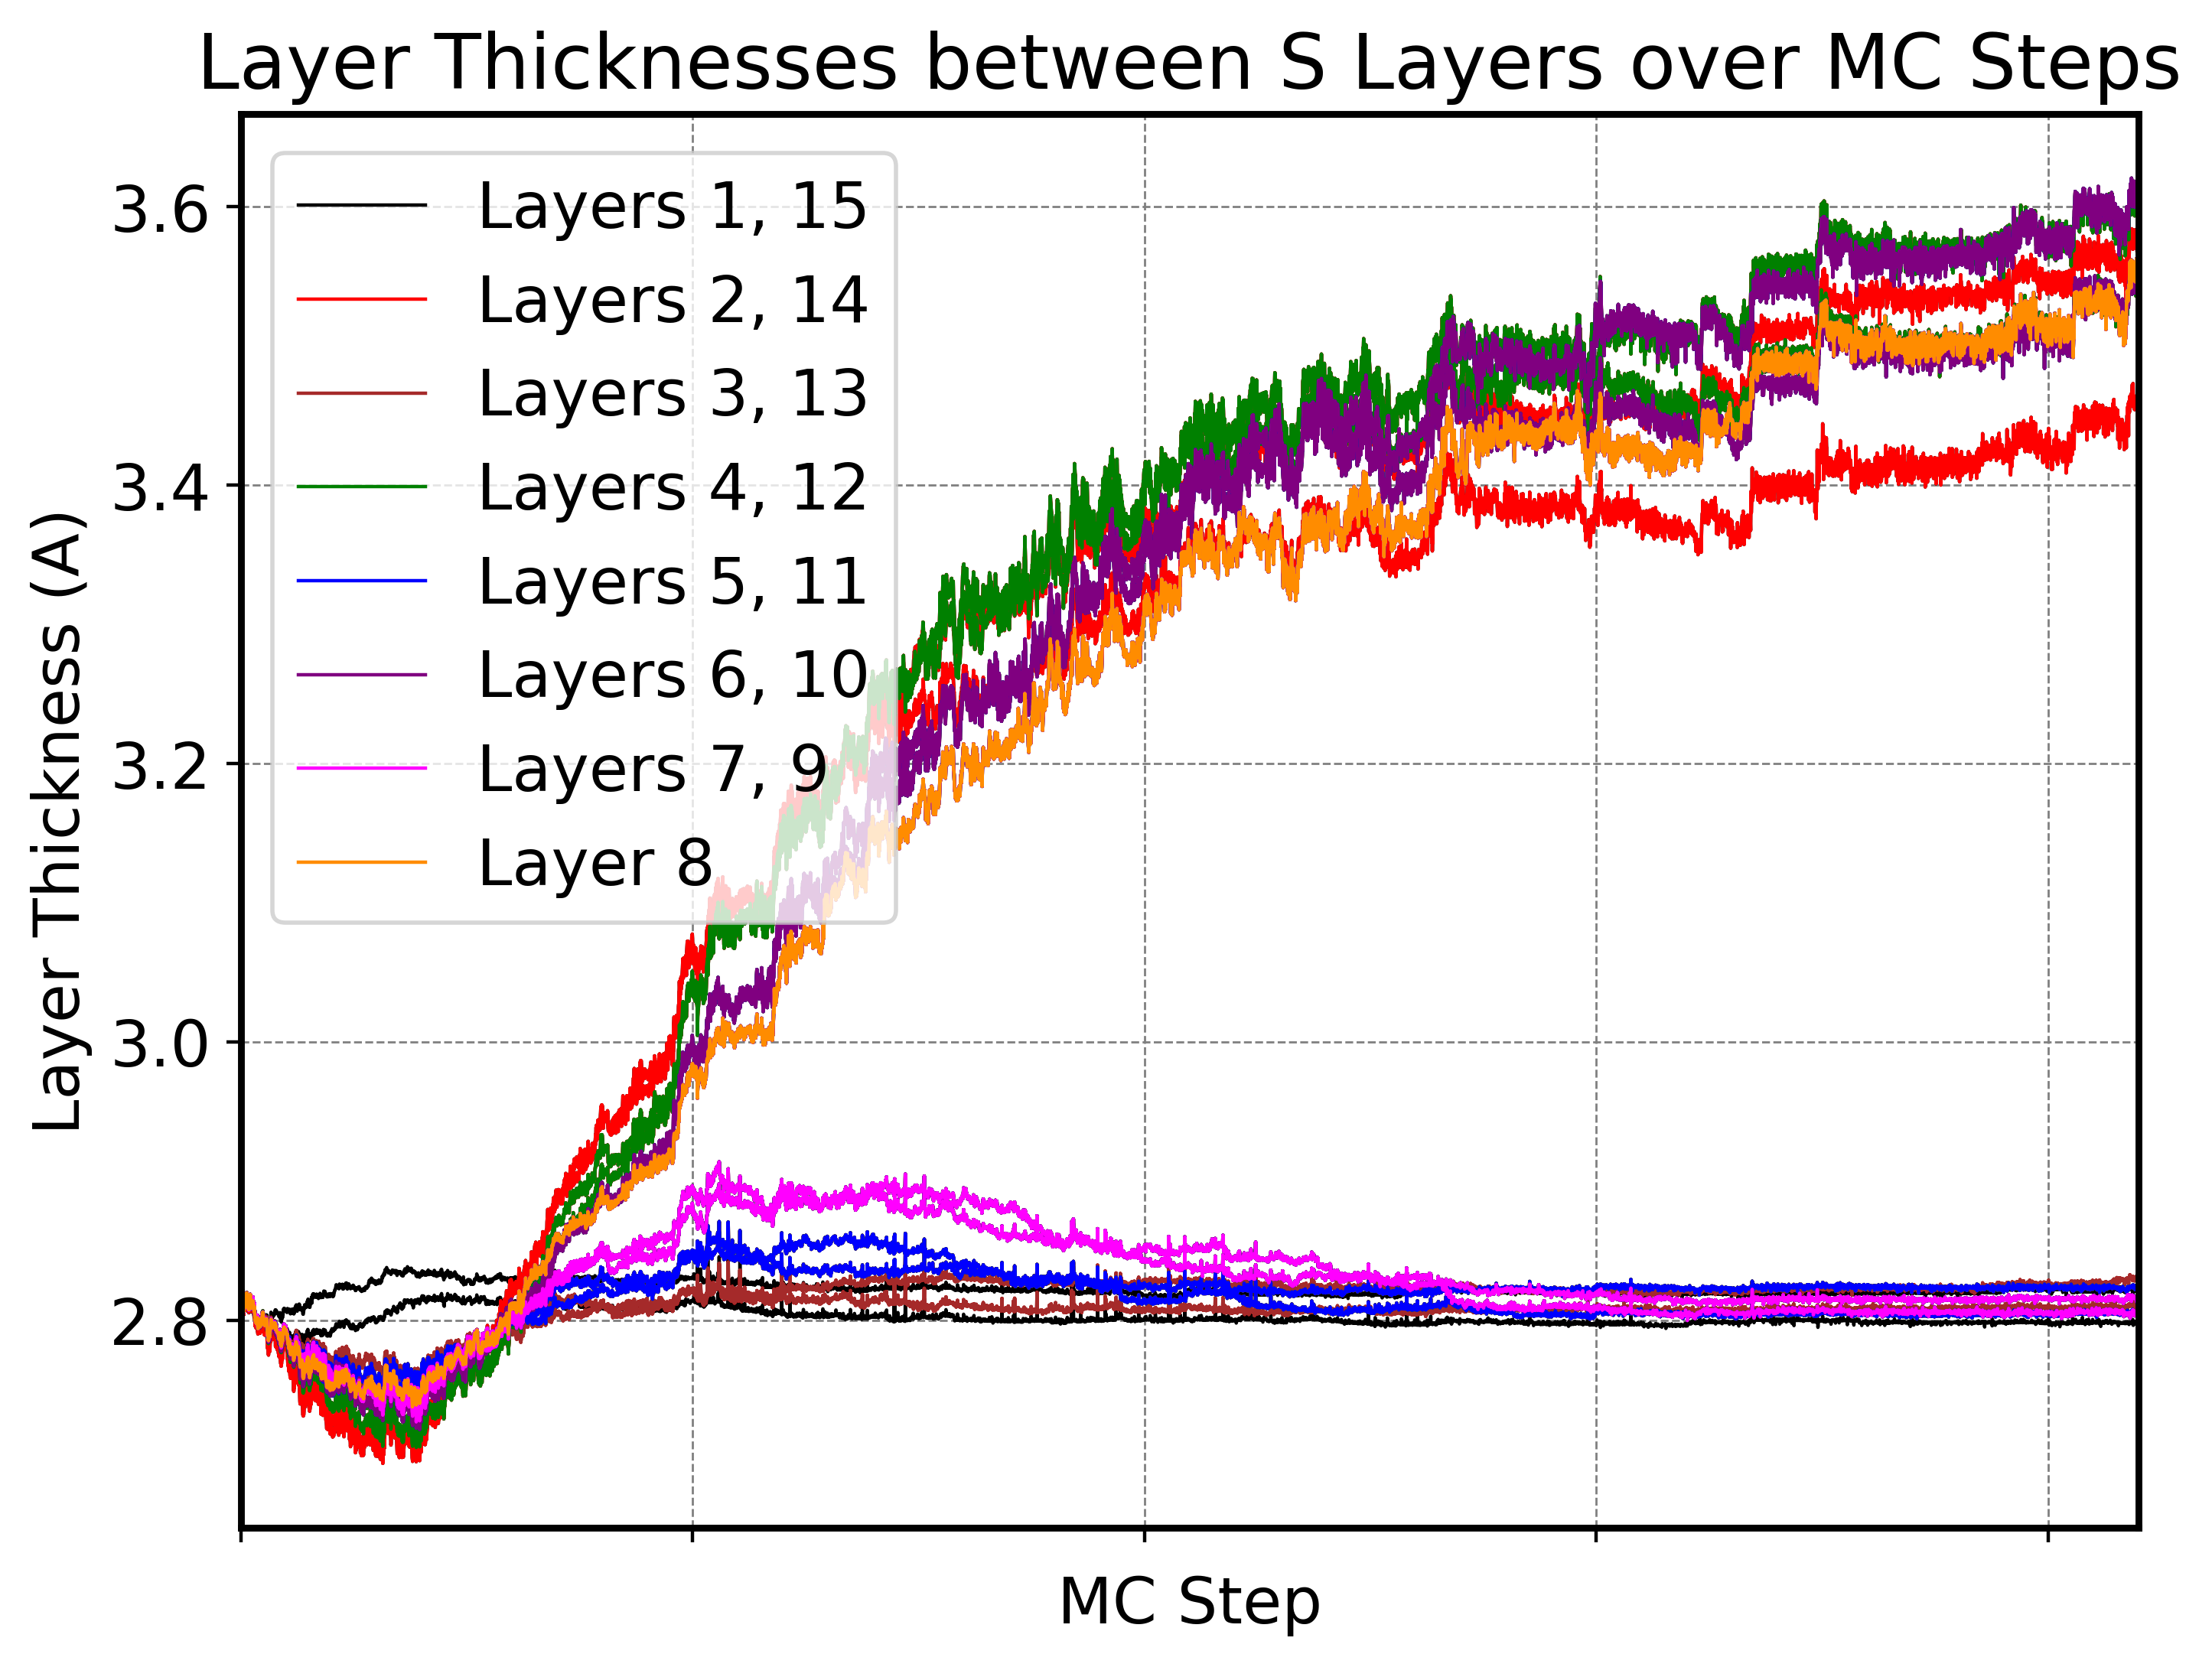

In [85]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Set the figure size
plt.figure(figsize=(8, 6), dpi=400)

line_thickness = 0.8

# Define the legend labels and corresponding layers
legend_labels = ['Layers 1, 15', 'Layers 2, 14', 'Layers 3, 13', 'Layers 4, 12', 'Layers 5, 11', 'Layers 6, 10', 'Layers 7, 9', 'Layer 8']
legend_layers = [(0, 14), (1, 13), (2, 12), (3, 11), (4, 10), (5, 9), (6, 8), (7, 7)]

# Define a list of colors to use
colors = ['black', 'red', 'brown', 'green', 'blue', 'purple', 'magenta', 'darkorange']

# Plot layer thicknesses over the MC steps with adjustable line thickness and assigned colors
for i, (start_layer, end_layer) in enumerate(legend_layers):
    color = colors[i % len(colors)]  # Cycle through the list of colors
    for layer in range(start_layer, end_layer+1):
        plt.plot(layer_thicknesses_traj[layer, :], label='Layer {}'.format(layer+1), linewidth=line_thickness, color=color)

# Set the x-axis and y-axis labels and the title of the plot
plt.xlabel('MC Step')
plt.ylabel('Layer Thickness (A)')
plt.title('Layer Thicknesses between S Layers over MC Steps')

# Set the x-axis ticks at every 2,000 steps
plt.xticks(np.arange(0, 8401, 2000))

# Remove tick labels
plt.gca().set_xticklabels([])
#plt.gca().set_yticklabels([])

# Set the x-axis limits to match the range of your data
plt.xlim(0, 8400)

# Create custom legend with desired colors
custom_legend = [Line2D([], [], color=colors[i % len(colors)], linewidth=line_thickness) for i in range(len(legend_labels))]

# Move the legend to the side of the plot
plt.legend(custom_legend, legend_labels, loc='center left', bbox_to_anchor=(0, 0.7))
# Add grid
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.rcParams["axes.linewidth"] = 1.6

plt.savefig('layer_thickness_1.png')
# Show the plot
plt.show()


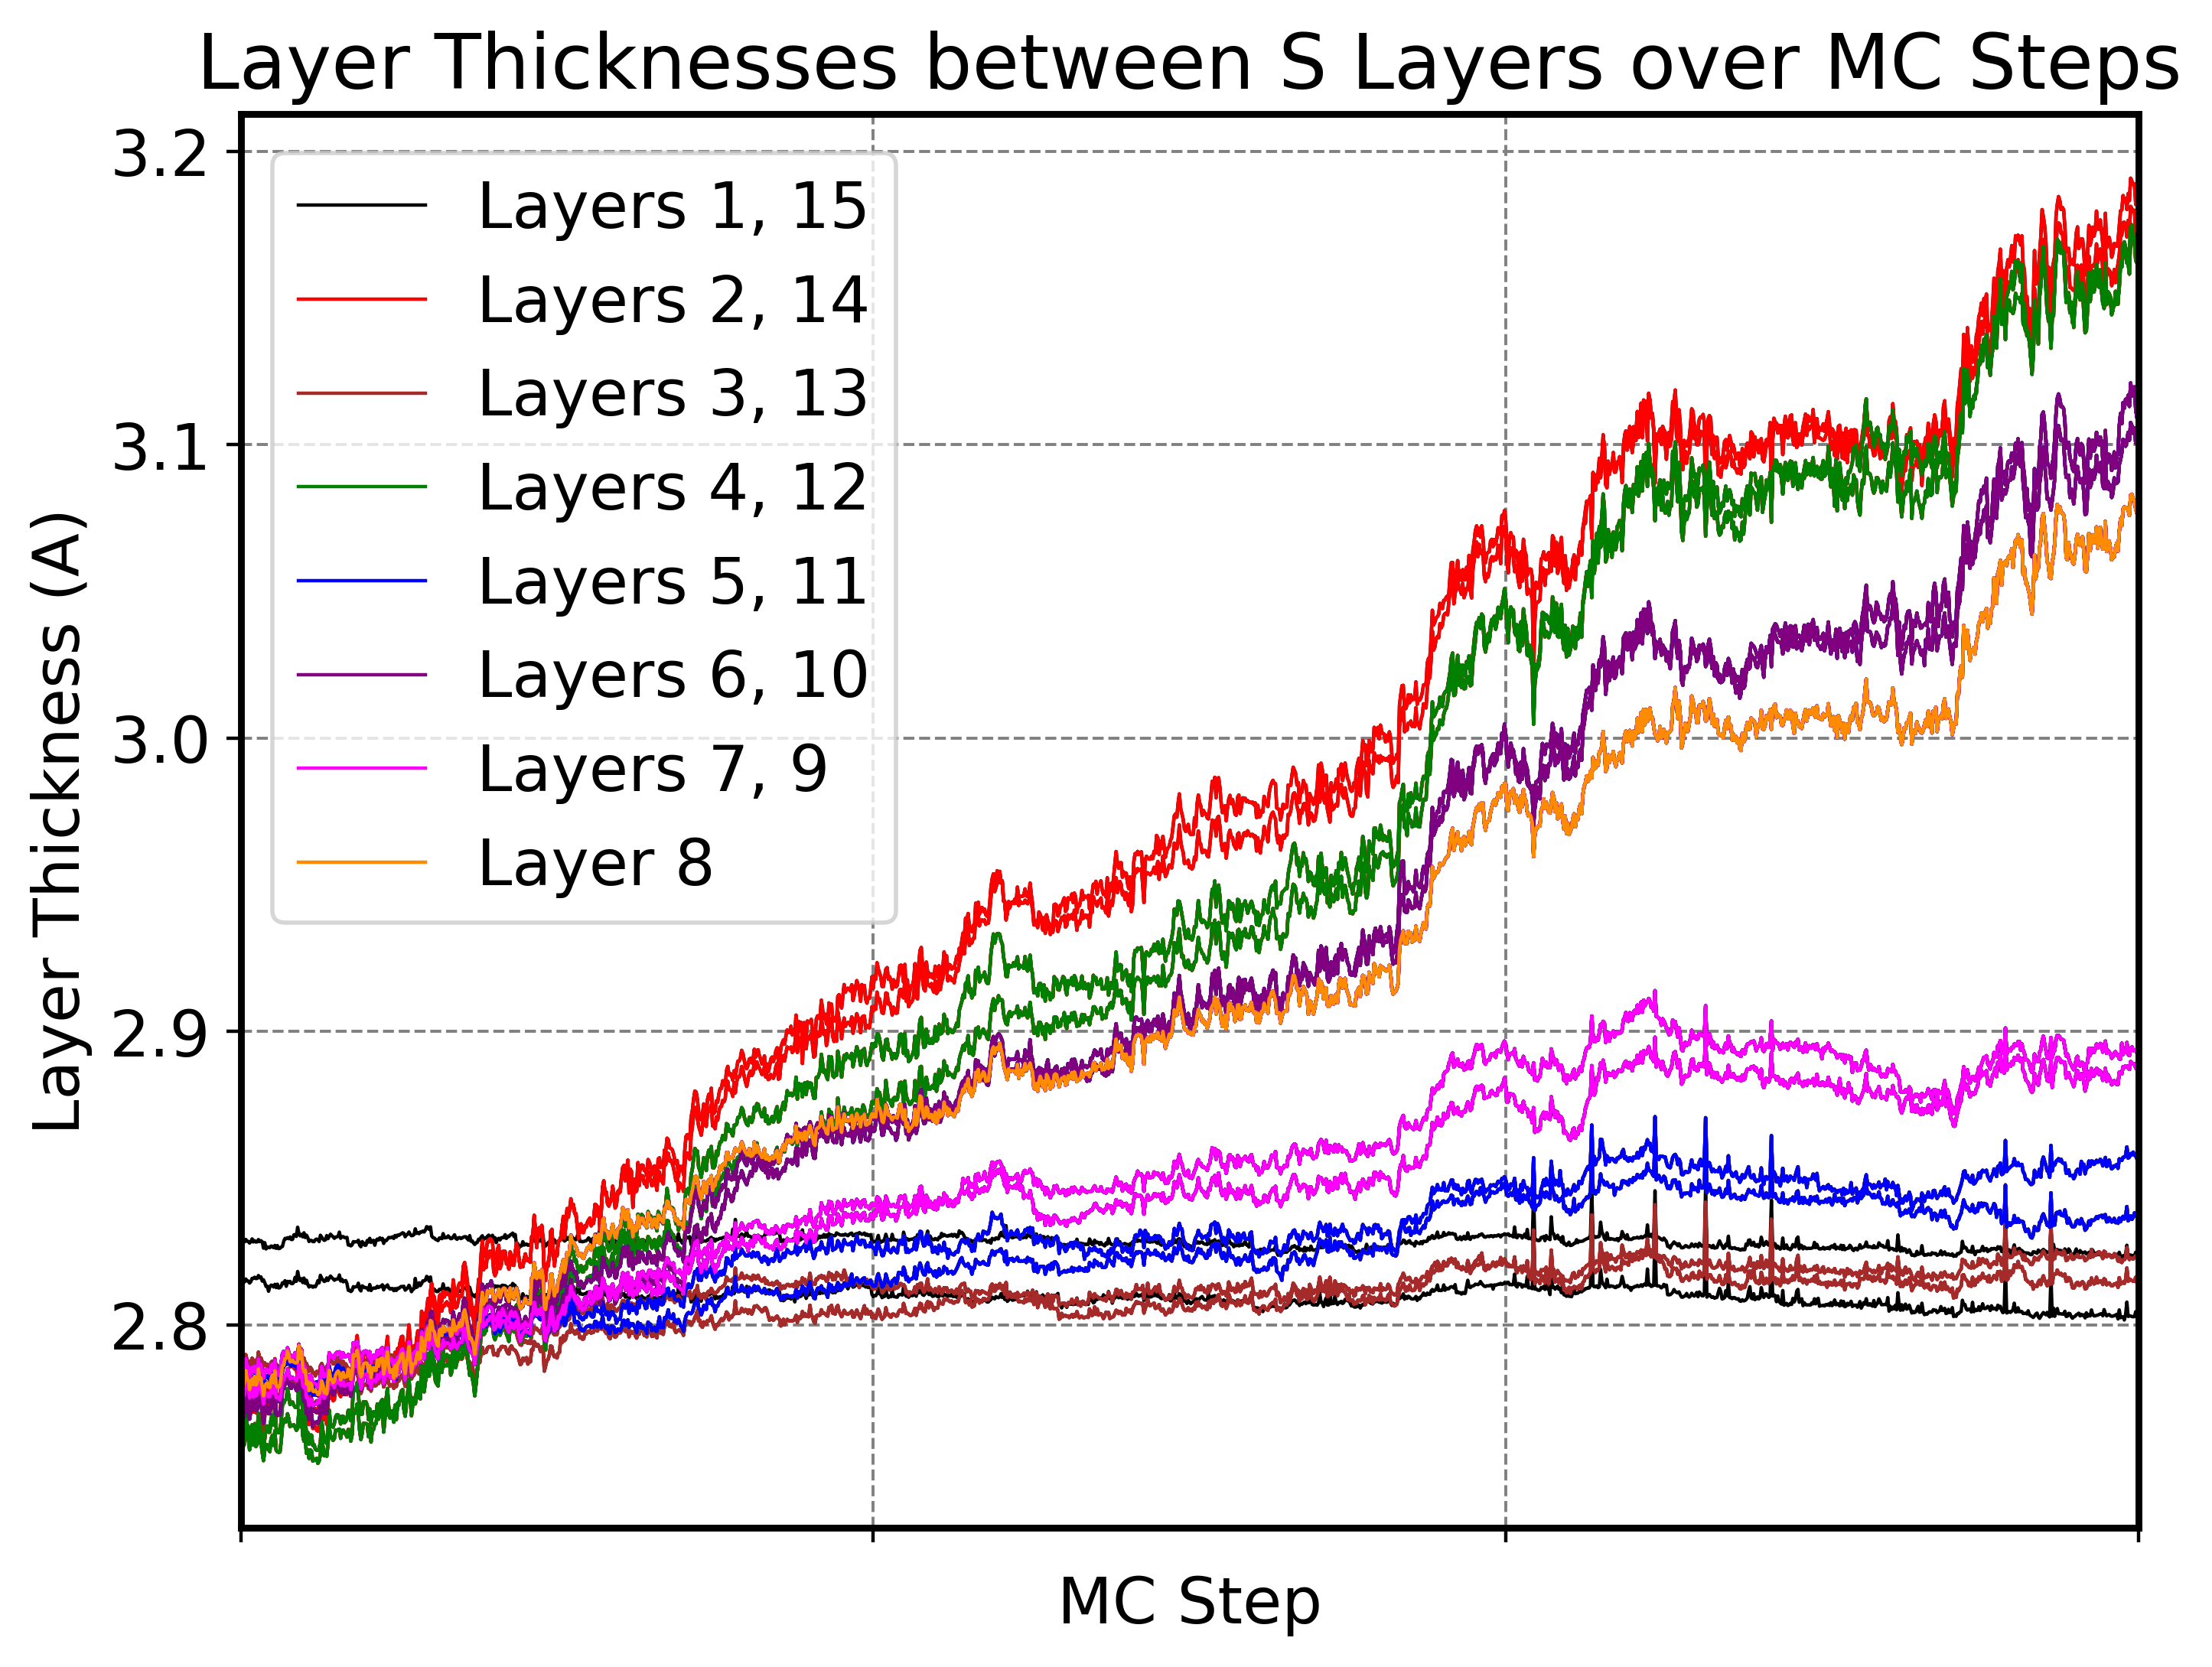

In [88]:
# Set the figure size
plt.figure(figsize=(8, 6), dpi=400)

line_thickness = 0.8

# Define the legend labels and corresponding layers
legend_labels = ['Layers 1, 15', 'Layers 2, 14', 'Layers 3, 13', 'Layers 4, 12', 'Layers 5, 11', 'Layers 6, 10', 'Layers 7, 9', 'Layer 8']
legend_layers = [(0, 14), (1, 13), (2, 12), (3, 11), (4, 10), (5, 9), (6, 8), (7, 7)]

# Define a list of colors to use
colors = ['black', 'red', 'brown', 'green', 'blue', 'purple', 'magenta', 'darkorange']

# Plot layer thicknesses over the MC steps with adjustable line thickness and assigned colors
for i, (start_layer, end_layer) in enumerate(legend_layers):
    color = colors[i % len(colors)]  # Cycle through the list of colors
    for layer in range(start_layer, end_layer+1):
        plt.plot(layer_thicknesses_traj[layer, 1000:2500], label='Layer {}'.format(layer+1), linewidth=line_thickness, color=color)

# Set the x-axis and y-axis labels and the title of the plot
plt.xlabel('MC Step')
plt.ylabel('Layer Thickness (A)')
plt.title('Layer Thicknesses between S Layers over MC Steps')


# Set the x-axis ticks at every 2,000 steps
plt.xticks(np.arange(0, 2000, 500))

# Set the x-axis limits to match the range of your data
plt.xlim(0, 1500)
# Create custom legend with desired colors
custom_legend = [Line2D([], [], color=colors[i % len(colors)], linewidth=line_thickness) for i in range(len(legend_labels))]

# Move the legend to the side of the plot
plt.legend(custom_legend, legend_labels, loc='center left', bbox_to_anchor=(0, 0.7))

# Remove tick labels
plt.gca().set_xticklabels([])
#plt.gca().set_yticklabels([])

# Add grid
plt.grid(True, linestyle='--', linewidth=0.7, color='gray')

plt.rcParams["axes.linewidth"] = 1.6

# Show the plot
plt.savefig('layer_thickness_2.png',transparent=False)
plt.show()

### Evolution of number of Cr per layer over MC steps

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read

def count_cr_atoms_in_layer(atoms, i_layer, layer_thickness=0.1):
    # Extract the atomic positions and element types
    positions = atoms.get_positions()
    elements = atoms.get_chemical_symbols()
    # Keep only the Cr/X atoms
    cr_x_indices = [i for i, at in enumerate(atoms) if (at.symbol == 'X' or at.symbol == 'Cr')]
    cr_x_positions = positions[cr_x_indices]
    # Extract the unique z-coordinates of the Cr/X atoms
    z_coords = np.unique(cr_x_positions[:, 2])
    # Count the number of Cr atoms in the ith layer
    n_cr_atoms = 0
    for j, index in enumerate(cr_x_indices):
        if cr_x_positions[j][2] >= (z_coords[i_layer]-0.1) and \
        cr_x_positions[j][2] < (z_coords[i_layer]+0.1):
            if atoms[index].symbol == 'Cr':
                n_cr_atoms += 1
    return n_cr_atoms

In [1358]:
n_cr_trajs = []
for i in range(0, len(all_structures), 25):
    if i%1000==0:
        print(i)
    atoms = all_structures[i]
    n_cr_traj = []
    for layer_i in range(15):
        n_cr_traj.append(count_cr_atoms_in_layer(atoms, layer_i))       
    n_cr_trajs.append(n_cr_traj)  

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000
147000
148000
149000
150000
151000
152000
153000
154000
155000
156000
157000
158000


In [1359]:
layer_cr_traj = []

# Create an empty 2D array to store the Cr atom counts at each z-coordinate and MC step
cr_count_map = np.zeros((15, len(n_cr_trajs)))

# Loop over each MC step and layer to count the number of Cr atoms in each layer
for i in range(len(n_cr_trajs)):
    for j in range(n_layers):
        # Store the number of Cr atoms in the jth layer at the ith MC step
        cr_count_map[j, i] = n_cr_trajs[i][j]
    
layer_cr_traj = np.array(cr_count_map)  

In [1360]:
layer_cr_traj.shape

(15, 8400)

In [1419]:
layer_cr_traj[-1]

array([152., 152., 152., ..., 285., 285., 285.])

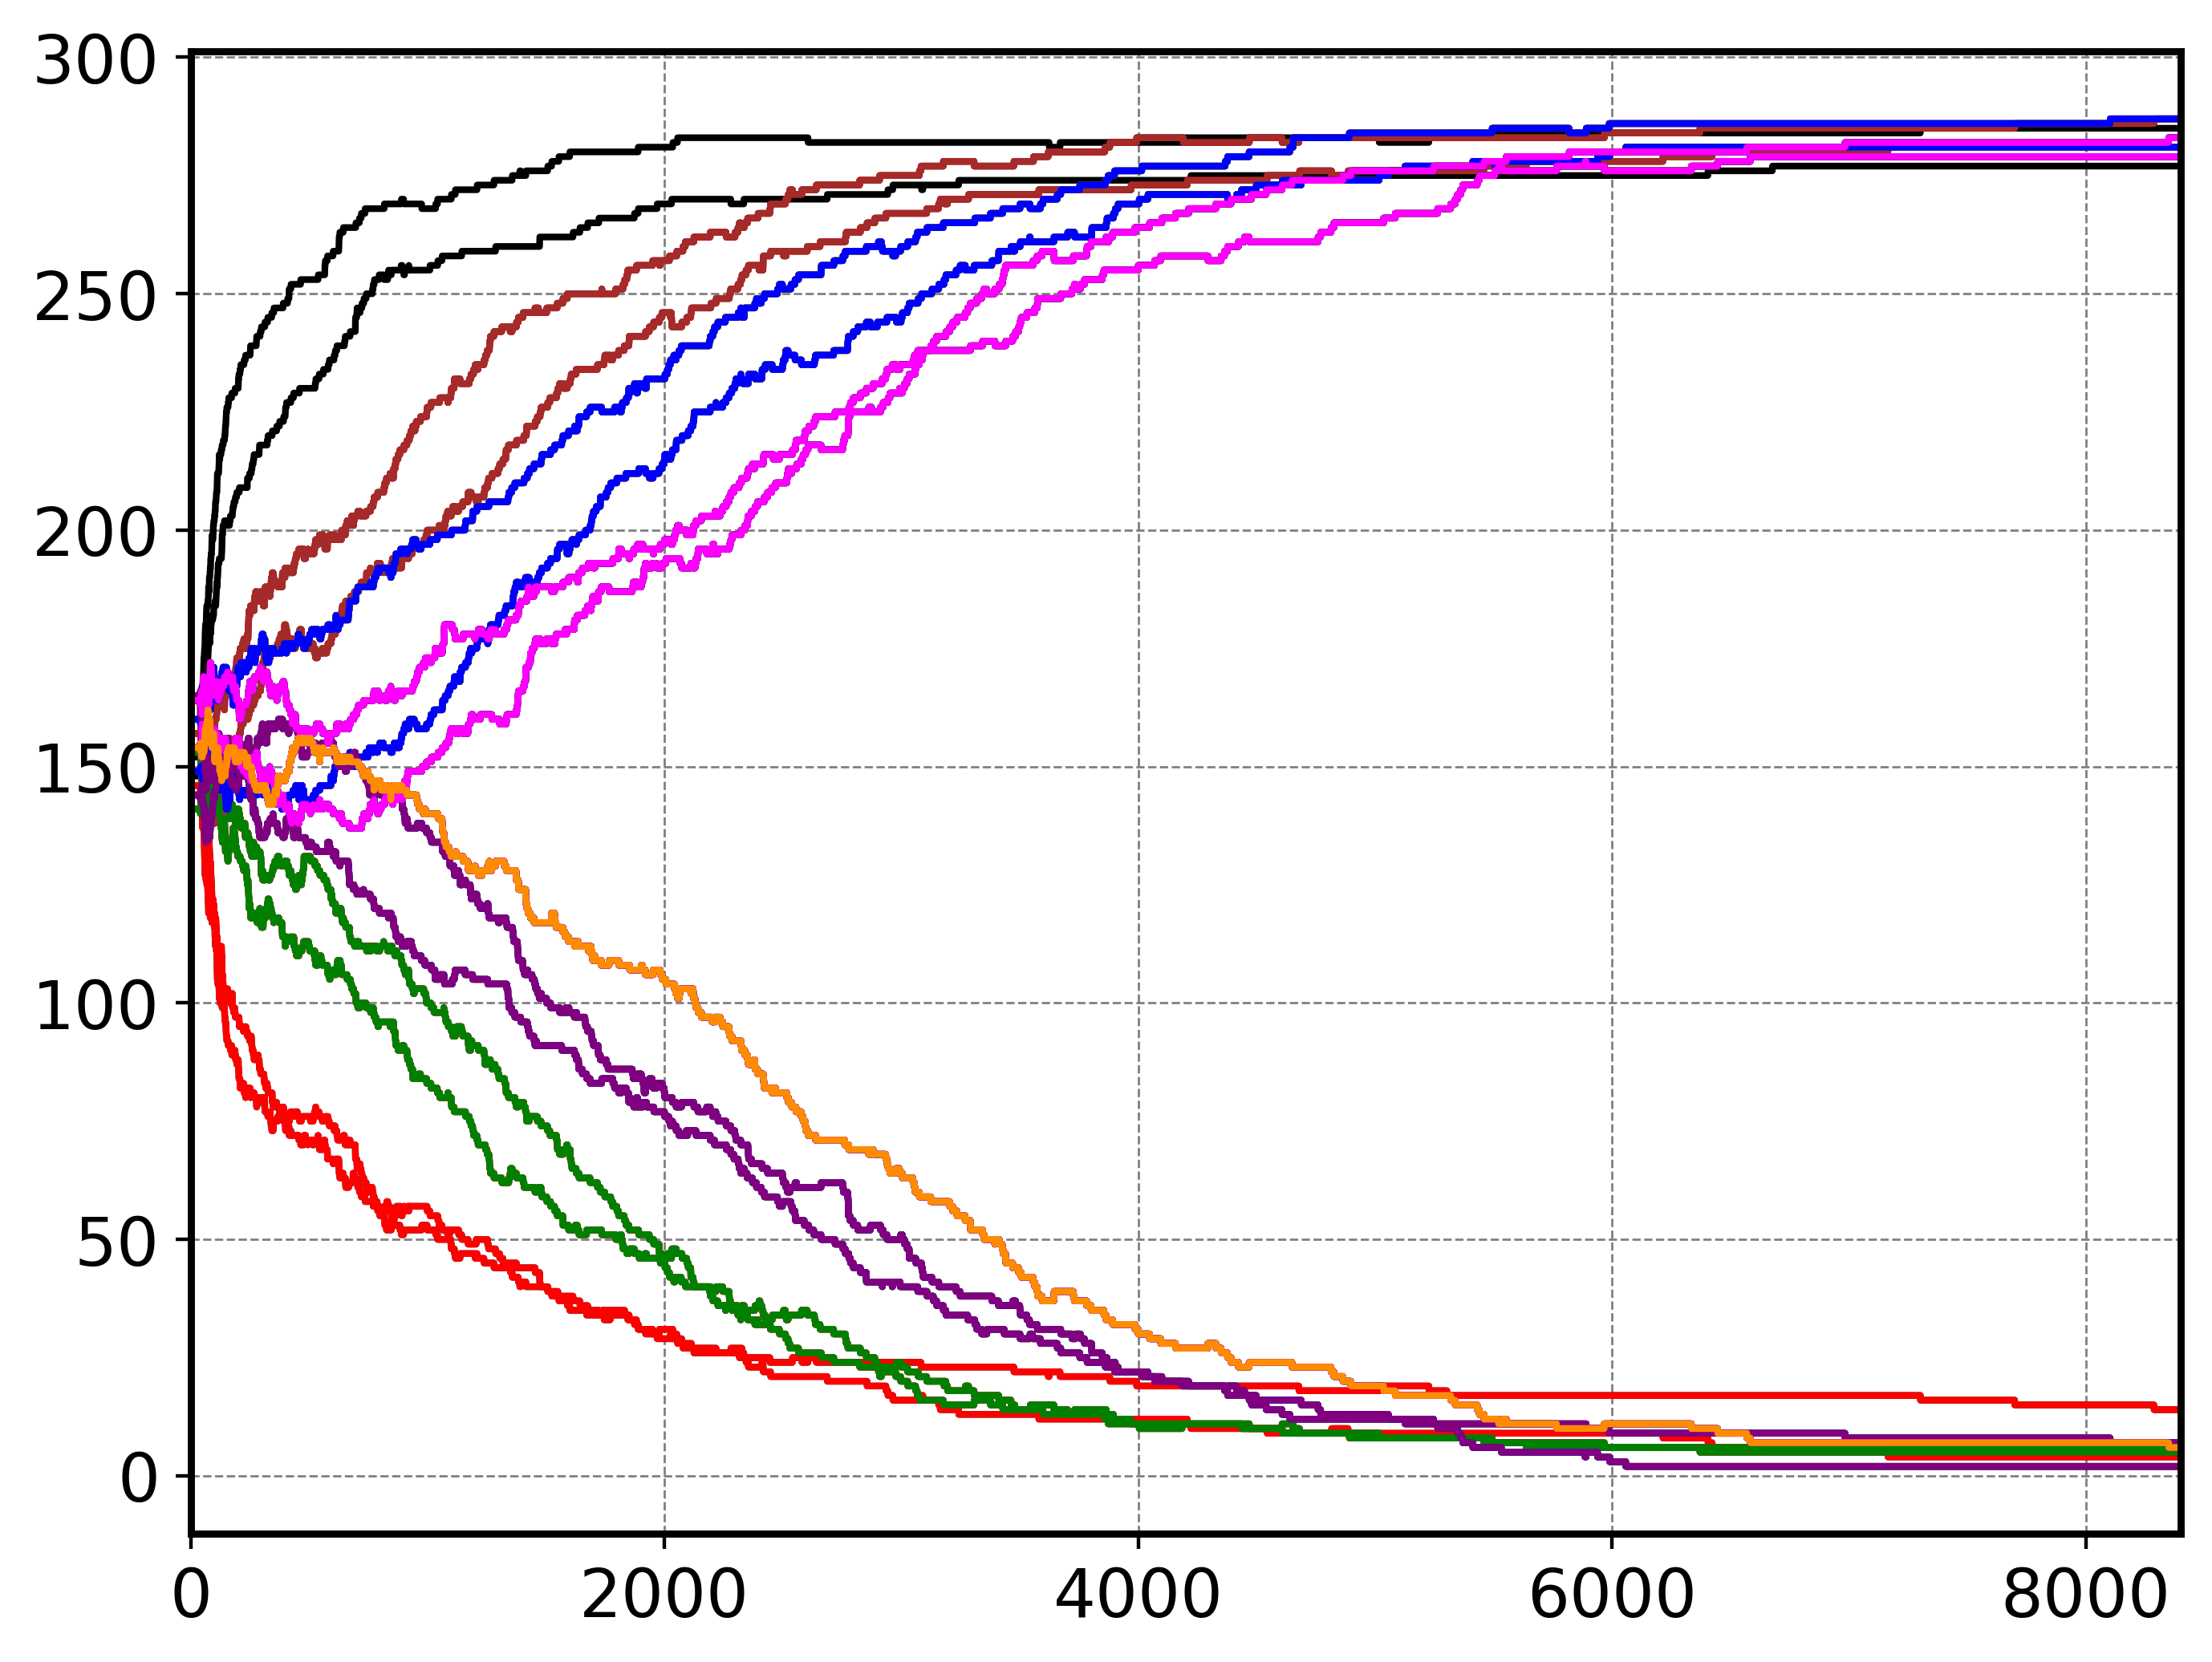

In [1399]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Set the figure size
plt.figure(figsize=(8, 6), dpi=400)

line_thickness = 1.5

# Define the legend labels and corresponding layers
legend_labels = ['Layers 1, 15', 'Layers 2, 14', 'Layers 3, 13', 'Layers 4, 12', 'Layers 5, 11', 'Layers 6, 10', 'Layers 7, 9', 'Layer 8']
legend_layers = [(0, 14), (1, 13), (2, 12), (3, 11), (4, 10), (5, 9), (6, 8), (7, 7)]

# Define a list of colors to use
colors = ['black', 'red', 'brown', 'green', 'blue', 'purple', 'magenta', 'darkorange']

# Plot layer thicknesses over the MC steps with adjustable line thickness and assigned colors
for i, (start_layer, end_layer) in enumerate(legend_layers):
    color = colors[i % len(colors)]  # Cycle through the list of colors
    for layer in range(start_layer, end_layer+1):
        plt.plot(layer_cr_traj[layer, :], label='Layer {}'.format(layer+1), linewidth=line_thickness, color=color)

# Set the x-axis and y-axis labels and the title of the plot
#plt.xlabel('MC Step')
#plt.ylabel('Layer Cr number of atoms')
#plt.title('Layer Cr number of atoms over MC Steps')

# Set the x-axis ticks at every 2,000 steps
plt.xticks(np.arange(0, 8401, 2000))

# Remove tick labels
#plt.gca().set_xticklabels([])
#plt.gca().set_yticklabels([])

# Set the x-axis limits to match the range of your data
plt.xlim(0, 8400)

# Create custom legend with desired colors
custom_legend = [Line2D([], [], color=colors[i % len(colors)], linewidth=line_thickness) for i in range(len(legend_labels))]

# Move the legend to the side of the plot
#plt.legend(custom_legend, legend_labels, loc='center left', bbox_to_anchor=(1, 0.8))

# Add grid
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.rcParams["axes.linewidth"] = 1.6

plt.savefig('layer_cr_traj.png')
# Show the plot
plt.show()


### Cr distribution profile

In [1363]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read

def count_cr_atoms_in_layer(atoms, i_layer, layer_thickness=0.1):
    # Extract the atomic positions and element types
    positions = atoms.get_positions()
    elements = atoms.get_chemical_symbols()
    # Keep only the Cr/X atoms
    cr_x_indices = [i for i, at in enumerate(atoms) if (at.symbol == 'X' or at.symbol == 'Cr')]
    cr_x_positions = positions[cr_x_indices]
    # Extract the unique z-coordinates of the Cr/X atoms
    z_coords = np.unique(cr_x_positions[:, 2])
    # Count the number of Cr atoms in the ith layer
    n_cr_atoms = 0
    for j, index in enumerate(cr_x_indices):
        if cr_x_positions[j][2] >= (z_coords[i_layer]-0.1) and \
        cr_x_positions[j][2] < (z_coords[i_layer]+0.1):
            if atoms[index].symbol == 'Cr':
                n_cr_atoms += 1
    return n_cr_atoms

In [1383]:
nn_cr_trajs = n_cr_trajs[0:2000]

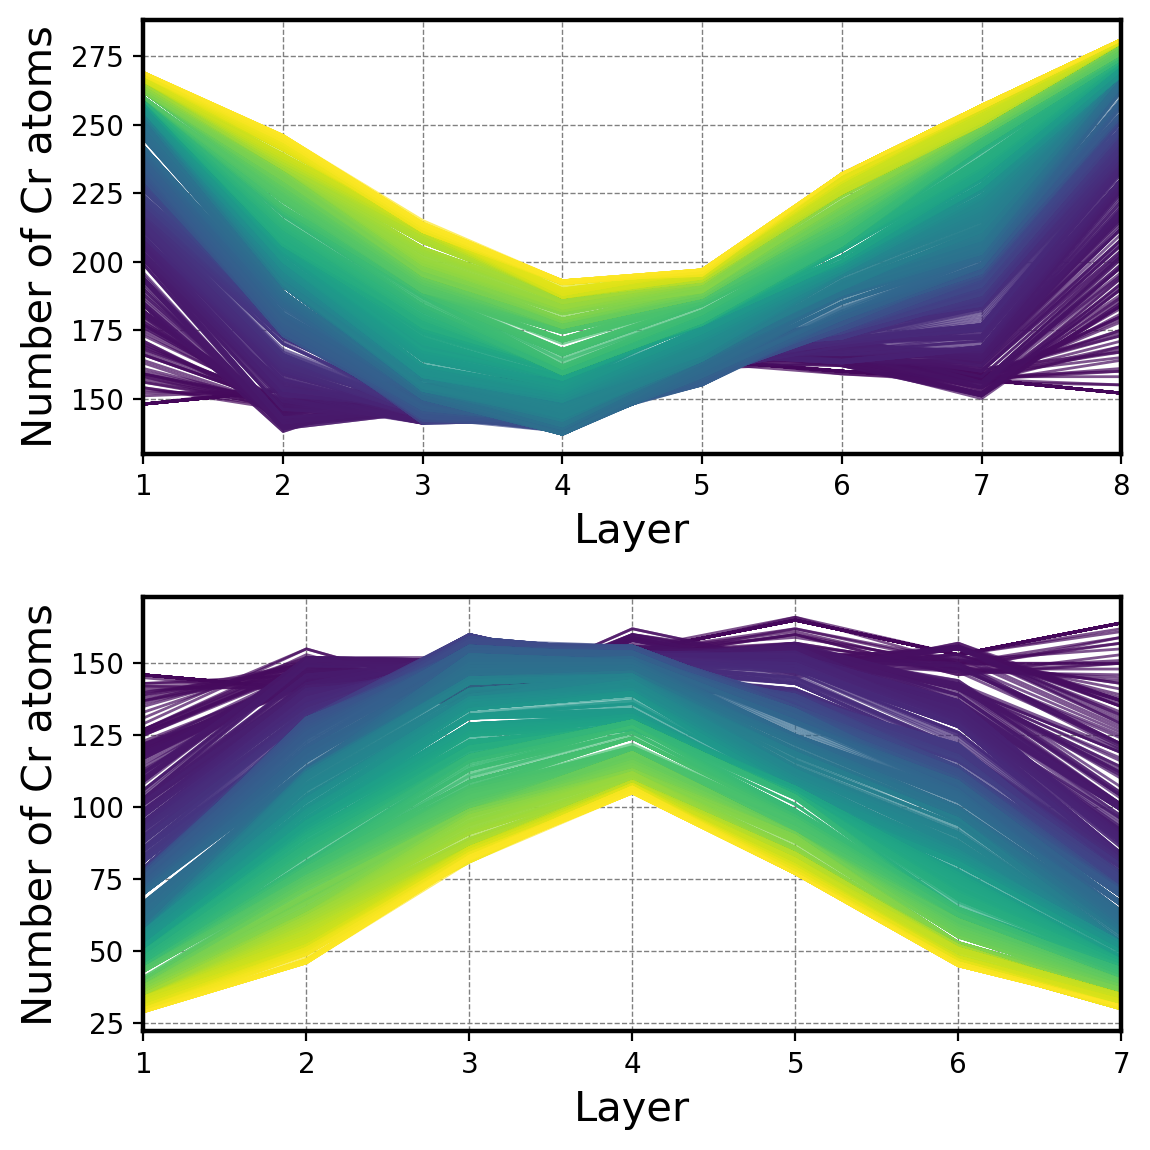

In [1384]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x1 subplot layout
fig, axs = plt.subplots(2, 1, figsize=(6, 6), dpi=200)  # Adjust the figsize and dpi as desired

# Unpack the axes
ax1, ax2 = axs.flatten()

nlayers = len(n_cr_trajs[0])

# Create a color map
cmap = plt.get_cmap('viridis')

# Iterate over the lists in n_cr_trajs
for i, nn_cr_traj in enumerate(nn_cr_trajs):
    
    # Split the even and odd layers
    crs2_layers = [nn_cr_traj[j] for j in range(len(nn_cr_traj)) if j % 2 == 0]
    vdw_layers = [nn_cr_traj[j] for j in range(len(nn_cr_traj)) if j % 2 != 0]
    
    # Create x-axis values
    x_crs2 = np.arange(1, 9)
    x_vdw = np.arange(1, 8)
    
    # Plot even layers as a line plot with dashed lines and gradient color
    ax1.plot(x_crs2, crs2_layers,
             color=cmap((i) / len(nn_cr_trajs)), alpha=0.7)
    ax1.set_ylabel("Number of Cr atoms")
    ax1.set_xlabel("Layer")
    ax1.set_xlim([1, 8])
    ax1.grid(True, linestyle='--', linewidth=0.5, color='gray')
    
    # Plot odd layers as a line plot with continuous lines and gradient color
    ax2.plot(x_vdw, vdw_layers, 
             color=cmap(i / len(nn_cr_trajs)), alpha=0.7)
    ax2.set_ylabel("Number of Cr atoms")
    ax2.set_xlabel("Layer")
    ax2.set_xlim([1, 7])
    ax2.grid(True, linestyle='--', linewidth=0.5, color='gray')

# Set line fonts and colors
for ax in axs.flatten():
    ax.xaxis.label.set_fontsize(15)
    ax.yaxis.label.set_fontsize(15)
    ax.tick_params(axis='both', labelsize=10)

# Adjust spacing between subplots
plt.tight_layout()

plt.rcParams["axes.linewidth"] = 1.6

plt.savefig('cr_profile_among_layers.png')

# Show the plot
plt.show()